A calibration spectrum was collected on a XXX detector from YYY. Six sources were used to generate this spectrum: $^{228}$Th, $^{133}$Ba, $^{241}$Am, $^{137}$Cs, $^{152}$Eu, and $^{60}$Co. For more information of these sources, see `data/sources.txt`. The sources were placed at a standoff distance of approximately 1 meter in order to eliminate any coincident effects. This data was collected over 3 days from January 11 to 14, 2019. Read in and plot the spectrum below:

In [1]:
#Import Statements
from utilities import *
from IPython.display import Image
import os
import numpy
numpy.random.seed(0)
from math import exp, sqrt
from math import log as ln
import pickle
import scipy.stats

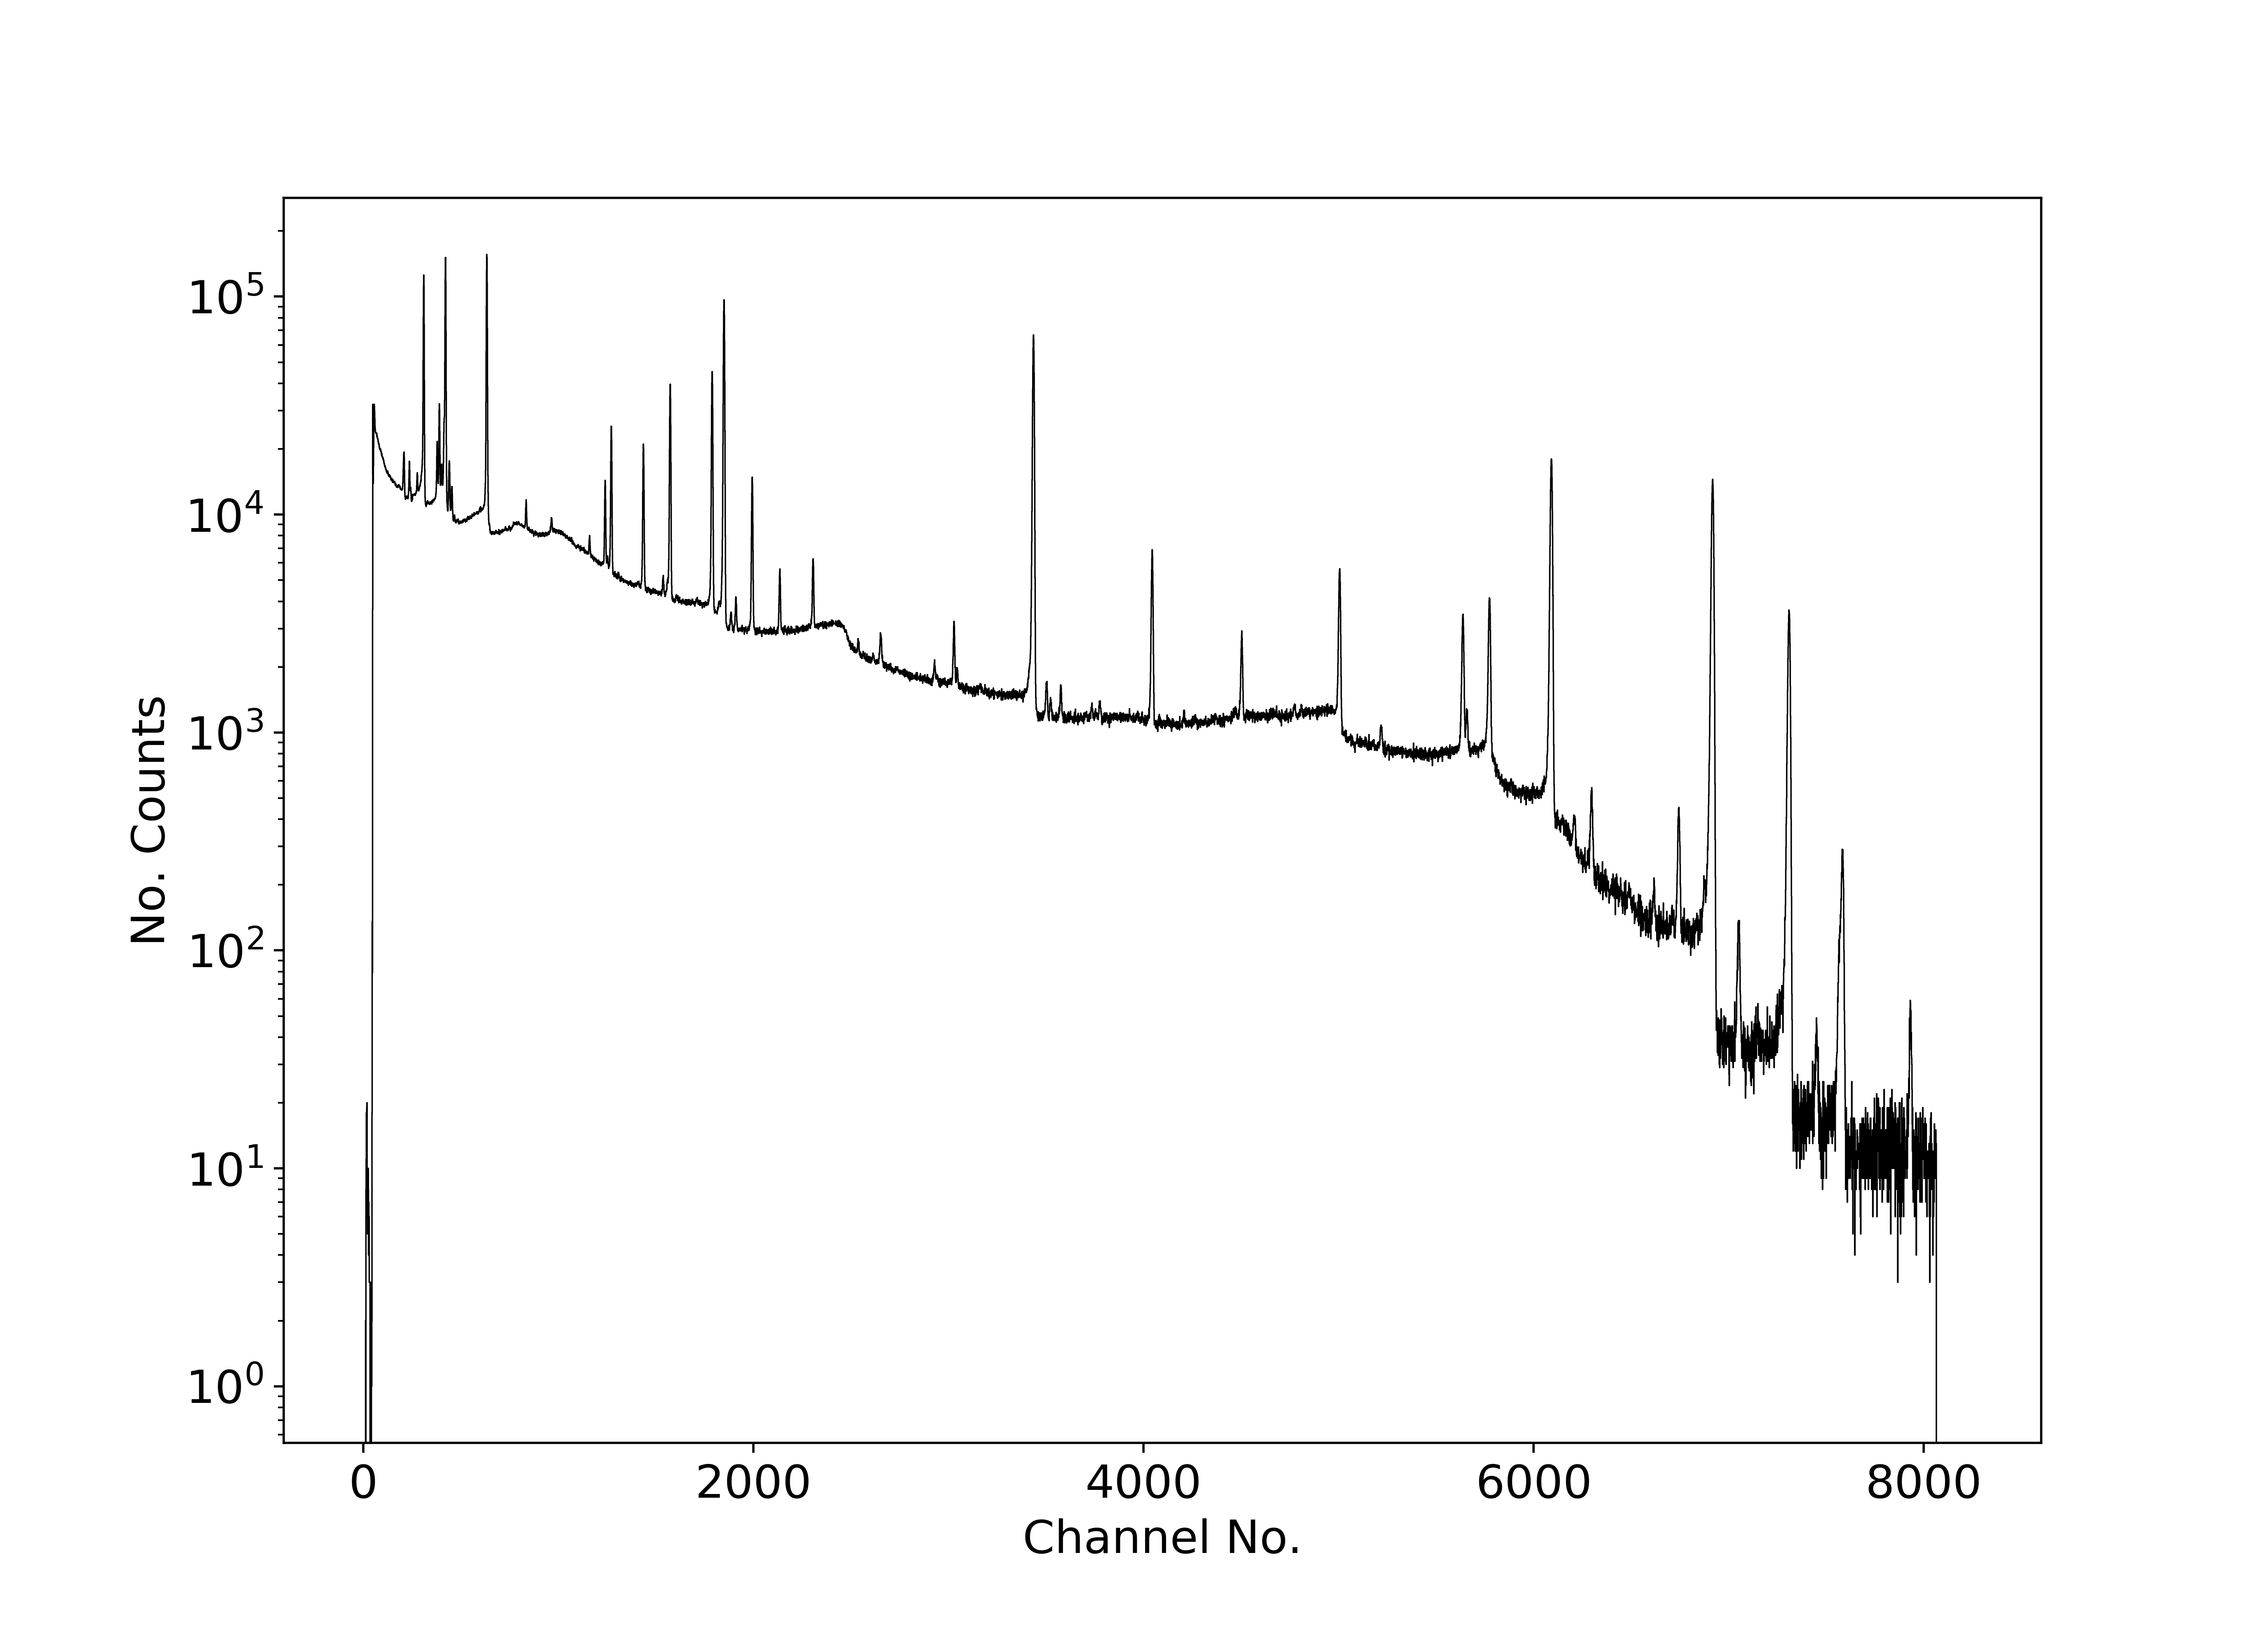

<Figure size 792x576 with 0 Axes>

In [2]:
file = open('../data/eu152_1_14_2019.Spe','r')
lines = file.readlines()
file.close()
data = [float(i) for i in lines[12:12+8192]]

plot_spectrum(data, display=False, file_out='../images/uncalibrated_spectrum.eps', logscale=True)
plot_spectrum(data, display=False, file_out='../images/uncalibrated_spectrum.png', fmt='png', logscale=True)
Image('../images/uncalibrated_spectrum.png')

The following gamma rays were identified:

| Source       | Energy (keV)  |
|--------------|---------------|
| $^{241}$Am   | 59.5409(1)    |
| $^{152}$Eu   | 121.7817(3)   |
| $^{212}$Pb*  | 238.632(2)    |
| $^{152}$Eu   | 244.6974(8)   |
| $^{133}$Ba   | 276.3989(12)  |
| $^{133}$Ba   | 302.0129(5)   |
| $^{152}$Eu   | 344.2785(12)  |
| $^{133}$Ba   | 356.0192(7)   |
| $^{133}$Ba   | 383.8485(12)  |
| $^{152}$Eu   | 411.1165(12)  |
| $^{152}$Eu   | 443.9606(16)  |
| $^{152}$Eu   | 563.986(5)    |
| $^{208}$Tl*  | 583.187(2)    |
| $^{152}$Eu^  | 586.2648(26)  |
| $^{137}$Cs   | 661.657(3)    |
| $^{152}$Eu   | 778.9045(24)  |
| $^{152}$Eu   | 867.380(3)    |
| $^{152}$Eu   | 964.057(5)    |
| $^{152}$Eu   | 1085.837(10)  |
| $^{152}$Eu   | 1089.737(5)   |
| $^{152}$Eu   | 1112.076(3)   |
| $^{60}$Co    | 1173.228(3)   |
| $^{152}$Eu   | 1212.948(11)  |
| $^{152}$Eu   | 1299.142(8)   |
| $^{60}$Co    | 1332.492(4)   |
| $^{152}$Eu   | 1408.013(3)   |
| $^{152}$Eu   | 1528.10(4)    |

*Background gamma from $^{232}$Th.

^Eliminated from efficiency calculations do to contamination from $^{208}$Tl photopeak. 


The gamma rays from the $^{228}$Th source were not able to be distinguished from X-rays resulting from the Pb shielding. 

Now identify windows around each photopeak of interest in order to perform a fit:

In [3]:
energies     = [   59.5409,  121.7817,    244.6974,    276.3989,    302.0129,    344.2785,    356.0192,    383.8485,    411.1165,    443.9606,     563.986,     661.657,    778.9045,     867.380,     964.057,    1085.837,    1112.076,    1173.228,    1212.948,    1299.142,    1332.492,    1408.013,     1528.10 ]
energies_unc = [    0.0001,    0.0003,      0.0008,      0.0012,      0.0005,      0.0012,      0.0007,      0.0012,      0.0012,      0.0016,       0.005,       0.003,      0.0024,       0.003,       0.005,       0.010,       0.003,       0.003,       0.011,       0.008,       0.004,       0.003,        0.04 ]
windows      = [ [290,320], [620,650], [1257,1290], [1422,1450], [1555,1590], [1770,1805], [1830,1865], [1975,2010], [2120,2150], [2285,2320], [2910,2950], [3400,3460], [4015,4065], [4480,4525], [4980,5030], [5610,5680], [5730,5820], [6030,6125], [6260,6330], [6710,6770], [6830,6970], [7240,7360], [7890,7970] ]
n_peaks      = [         1,         1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           2,           1,           1,           1,           1,           1,           1,           1 ]

Now fit the data in each window an appropriate functional form (NOTE: this takes a considerable about of time, only run if necessary, toggle `rerun` variable to force fit analysis to run):

In [4]:
rerun = False #Toggle this to force fitting

#Define guess_overrides for each window
guess_overrides = []
for i in range(0,len(windows)):
    guess_overrides.append( [None]*9 )
guess_overrides[15] = [4e3,5635,2,1,2e4,5658,2,1,None,None,None,None,None]
guess_overrides[3] = [1.7e4,1435,2.5,0.3,None,None,None,None,None]

fits = []
fits_cov = []
nets = []
nets_unc = []
if( rerun or (not('fit0.txt' in os.listdir('../fits'))) ): #Obtain photopeak fits and covariance matrices
    #Obtain fit centroids and net counts centroids
    for i in range(0,len(windows)):
        window = windows[i]
        if( n_peaks[i] == 1 ):
            B = gauss_poly_fit(data,window[0],window[1],guess_override=guess_overrides[i])
            net = gauss_int( *B[0:4] )
            fits.append(B)
            nets.append(net)
        elif( n_peaks[i] == 2 ):
            B = gauss_gauss_poly_fit(data,window[0],window[1],guess_override=guess_overrides[i])
            net = gauss_int( *B[0:4] )
            fits.append(B)
            nets.append(net)
        elif( n_peaks[i] == 3 ):
            B = gauss_gauss_gauss_poly_fit(data,window[0],window[1],guess_override=guess_overrides[i])
            net = gauss_int( *B[8:12] )
            fits.append(B)
            nets.append(net)


    #Obtain fit covariance matrices by Monte-Carlo variance
    trials = 1000
    trials_res = []
    nets_trials = []
    for i in range(0,len(windows)):
        trials_res.append( numpy.zeros( (len(fits[i]),trials) ) )
        nets_trials.append([])
    for n in range(0,trials):
        data_vard = numpy.random.poisson( data )
        for i in range(0,len(windows)):
            window = windows[i]
            if( n_peaks[i] == 1 ):
                try:
                    B = gauss_poly_fit(data_vard,window[0],window[1])
                    net = gauss_int( *B[0:4] )
                    nets_trials[i].append( net )
                except ValueError as e:
                    B = [float('nan')]*len(fits[i])
            elif( n_peaks[i] == 2 ):
                try:
                    B = gauss_gauss_poly_fit(data_vard,window[0],window[1],guess_override=[4e3,5637,2,1,2e4,5656.5,2,1,None,None,None,None,None])
                    net = gauss_int( *B[0:4] )
                    nets_trials[i].append( net )
                except ValueError as e:
                    B = [float('nan')]*len(fits[i])
            elif( n_peaks[i] == 3 ):
                try:
                    B = gauss_gauss_gauss_poly_fit(data_vard,window[0],window[1],guess_override=[1.5e4,1239,2,1,7e3,1252,2,1,2.5e4,1272,2,1,None,None,None,None,None])
                    net = gauss_int( *B[8:12] )
                    nets_trials[i].append( net )
                except ValueError as e:
                    B = [float('nan')]*len(fits[i])
            trials_res[i][:,n] = B

    for i in range(0,len(windows)):
        cov_mat = trials_res[i]
        cov_mat = cov_mat[:,~numpy.all(numpy.isnan(cov_mat),axis=0)]
        fits_cov.append( numpy.cov( cov_mat ) )
        nets_unc.append( numpy.std(nets_trials[i]) )


    #Save each fit and covariance matrix to file
    for i in range(0,len(windows)):
        file = open('../fits/fit' + str(i) + '.txt','w')
        file.write(str(energies[i]) + ' keV Photopeak\n')
        file.write('\n')
        file.write('Net Area:\n')
        file.write( str(nets[i]) + ' +/- ' + str(nets_unc[i]) + '\n' )
        file.write('\n')
        file.write('Fit:\n')
        for j in range(0,len(fits[i])):
            file.write( str(fits[i][j]) + ' ' )
        file.write('\n')
        file.write('\n')
        file.write('Covariance Matrix:\n')
        for p in range(0,len(fits[i])):
            for q in range(0,len(fits[i])):
                file.write( str(fits_cov[i][p,q]) + ' ' )
            file.write('\n')
        file.close()

    #Plot each fit
    for i in range(0,len(windows)):
        window = windows[i]
        plt.errorbar( range(window[0],window[1]), data[window[0]:window[1]], yerr=numpy.sqrt(data[window[0]:window[1]]), label='Count Data', fmt='b.', capsize=1.0 )
        x_data = numpy.linspace(window[0],window[1],1000)
        if( n_peaks[i] == 1 ):
            fit_data = gauss_poly(x_data,*fits[i])
            bg_data = poly5(x_data,*fits[i][4:])
            plt.plot( x_data, bg_data, 'k', label='Background' )
            plt.plot( x_data, fit_data, 'r', label='Fit' )
        elif( n_peaks[i] == 2 ):
            fit_data = gauss_gauss_poly(x_data,*fits[i])
            bg_data = poly5(x_data,*fits[i][8:])
            plt.plot( x_data, bg_data, 'k', label='Background' )
            plt.plot( x_data, fit_data, 'r', label='Fit' )
        elif( n_peaks[i] == 3 ):
            fit_data = gauss_gauss_gauss_poly(x_data,*fits[i])
            bg_data = poly5(x_data,*fits[i][12:])
            plt.plot( x_data, bg_data, 'k', label='Background' )
            plt.plot( x_data, fit_data, 'r', label='Fit' )
        plt.xlabel('Channel No.')
        plt.ylabel('Counts')
        plt.legend()
        plt.title( str(energies[i]) + ' keV' )
        plt.yscale('log')
        plt.savefig( '../fits/fit' + str(i) + '.png', dpi=500 )
        plt.savefig( '../fits/fit' + str(i) + '.eps', format='eps' )
        plt.clf()

else: #Read in save fits
    for i in range(0,len(windows)):
        file = open('../fits/fit' + str(i) + '.txt','r')
        lines = file.readlines()
        file.close()
        
        nets.append( float(lines[3].split('+/-')[0]) )
        nets_unc.append( float(lines[3].split('+/-')[1]) )
        
        B = [float(j) for j in lines[6].split()]
        B_cov = numpy.zeros( (len(B),len(B)) )
        
        for p in range(0,len(B)):
            for q in range(0,len(B)):
                try:
                    B_cov[p,q] = float( lines[9+p].split()[q] )
                except ValueError as e:
                    B_cov[p,q] = 0.0
        
        fits.append(B)
        fits_cov.append(B_cov)

The fit to the 563.986 keV line from $^{152}$Eu is poor due to very low counting statistics. Remove it from the dataset:

In [5]:
#Delete index 10 which corresponds to this line
del energies[10]
del energies_unc[10]
del windows[10]
del n_peaks[10]
del fits[10]
del fits_cov[10]
del nets[10]
del nets_unc[10]

The fit to the 276.3989 keV line from $^{133}$Ba has larger residuals around channel 1428 near the location of the 274.80 keV line from $^{214}$Pb. Moreover, the counts in this photopeak seem to be overpredicted. There is indeed a photopeak at the location of the stronger 295.2228 keV photopeak from $^{214}$Pb, affirming contamination from this line. $^{238}$U sources are indeed present in the room and $^{214}$Pb is in the $^{238}$U decay chain. Thus reject this point from the dataset:

In [6]:
#Delete index 3 which corresponds to this line
del energies[3]
del energies_unc[3]
del windows[3]
del n_peaks[3]
del fits[3]
del fits_cov[3]
del nets[3]
del nets_unc[3]

Now an energy calibration needs to be obtained. Use a linear energy calibration form.

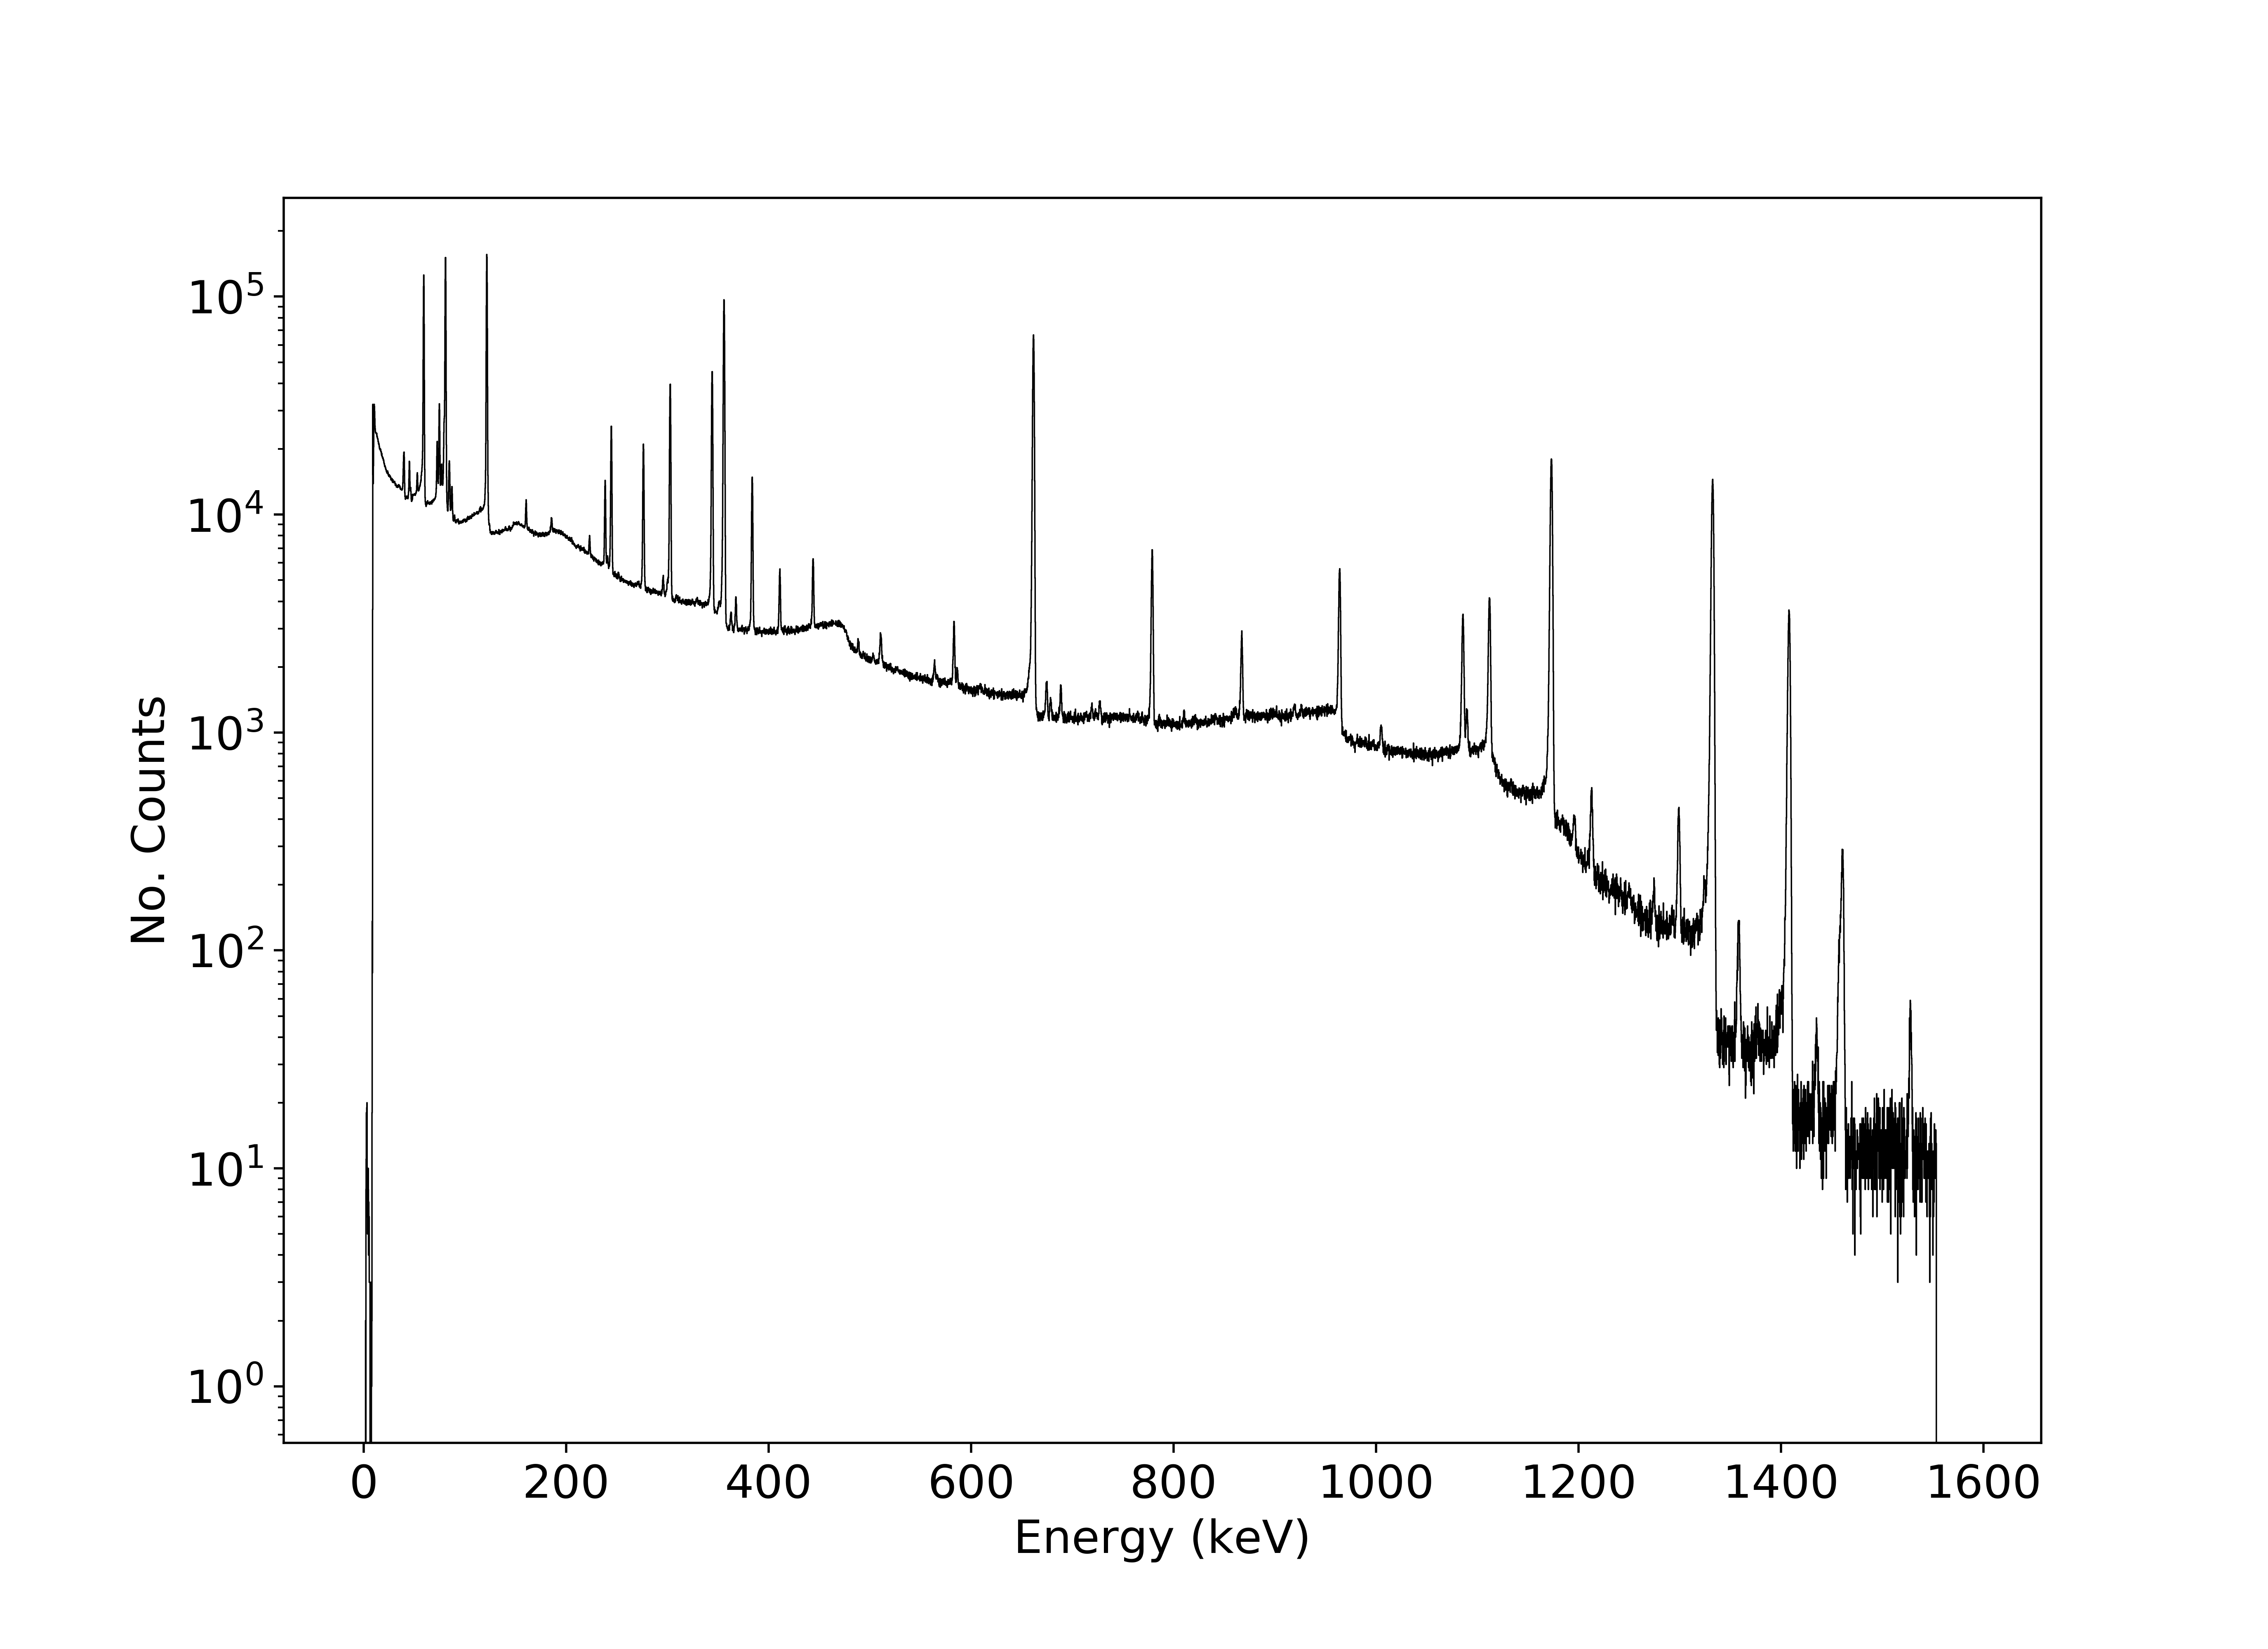

<Figure size 792x576 with 0 Axes>

In [7]:
#Obtain the energy calibration
centroids = []
centroids_unc = []
for i in range(0,len(windows)):
    if( n_peaks[i] == 1 ):
        centroids.append( fits[i][1] )
        centroids_unc.append( fits_cov[i][1,1] )
    elif( n_peaks[i] == 2 ):
        centroids.append( fits[i][1] )
        centroids_unc.append( fits_cov[i][1,1] )
    elif( n_peaks[i] == 3 ):
        centroids.append( fits[i][9] )
        centroids_unc.append( fits_cov[i][9,9] )

B_eng = energy_cal_fit( centroids, energies )
B_eng_cov = energy_cal_fit_cov( centroids, energies, centroids_unc, energies_unc )


#Plot the calibrated spectrum
plot_spectrum(data, display=False, energy_cal_in=B_eng, file_out='../images/spectrum.eps', logscale=True)
plot_spectrum(data, display=False, energy_cal_in=B_eng, file_out='../images/spectrum.png', fmt='png', logscale=True)
Image('../images/spectrum.png')

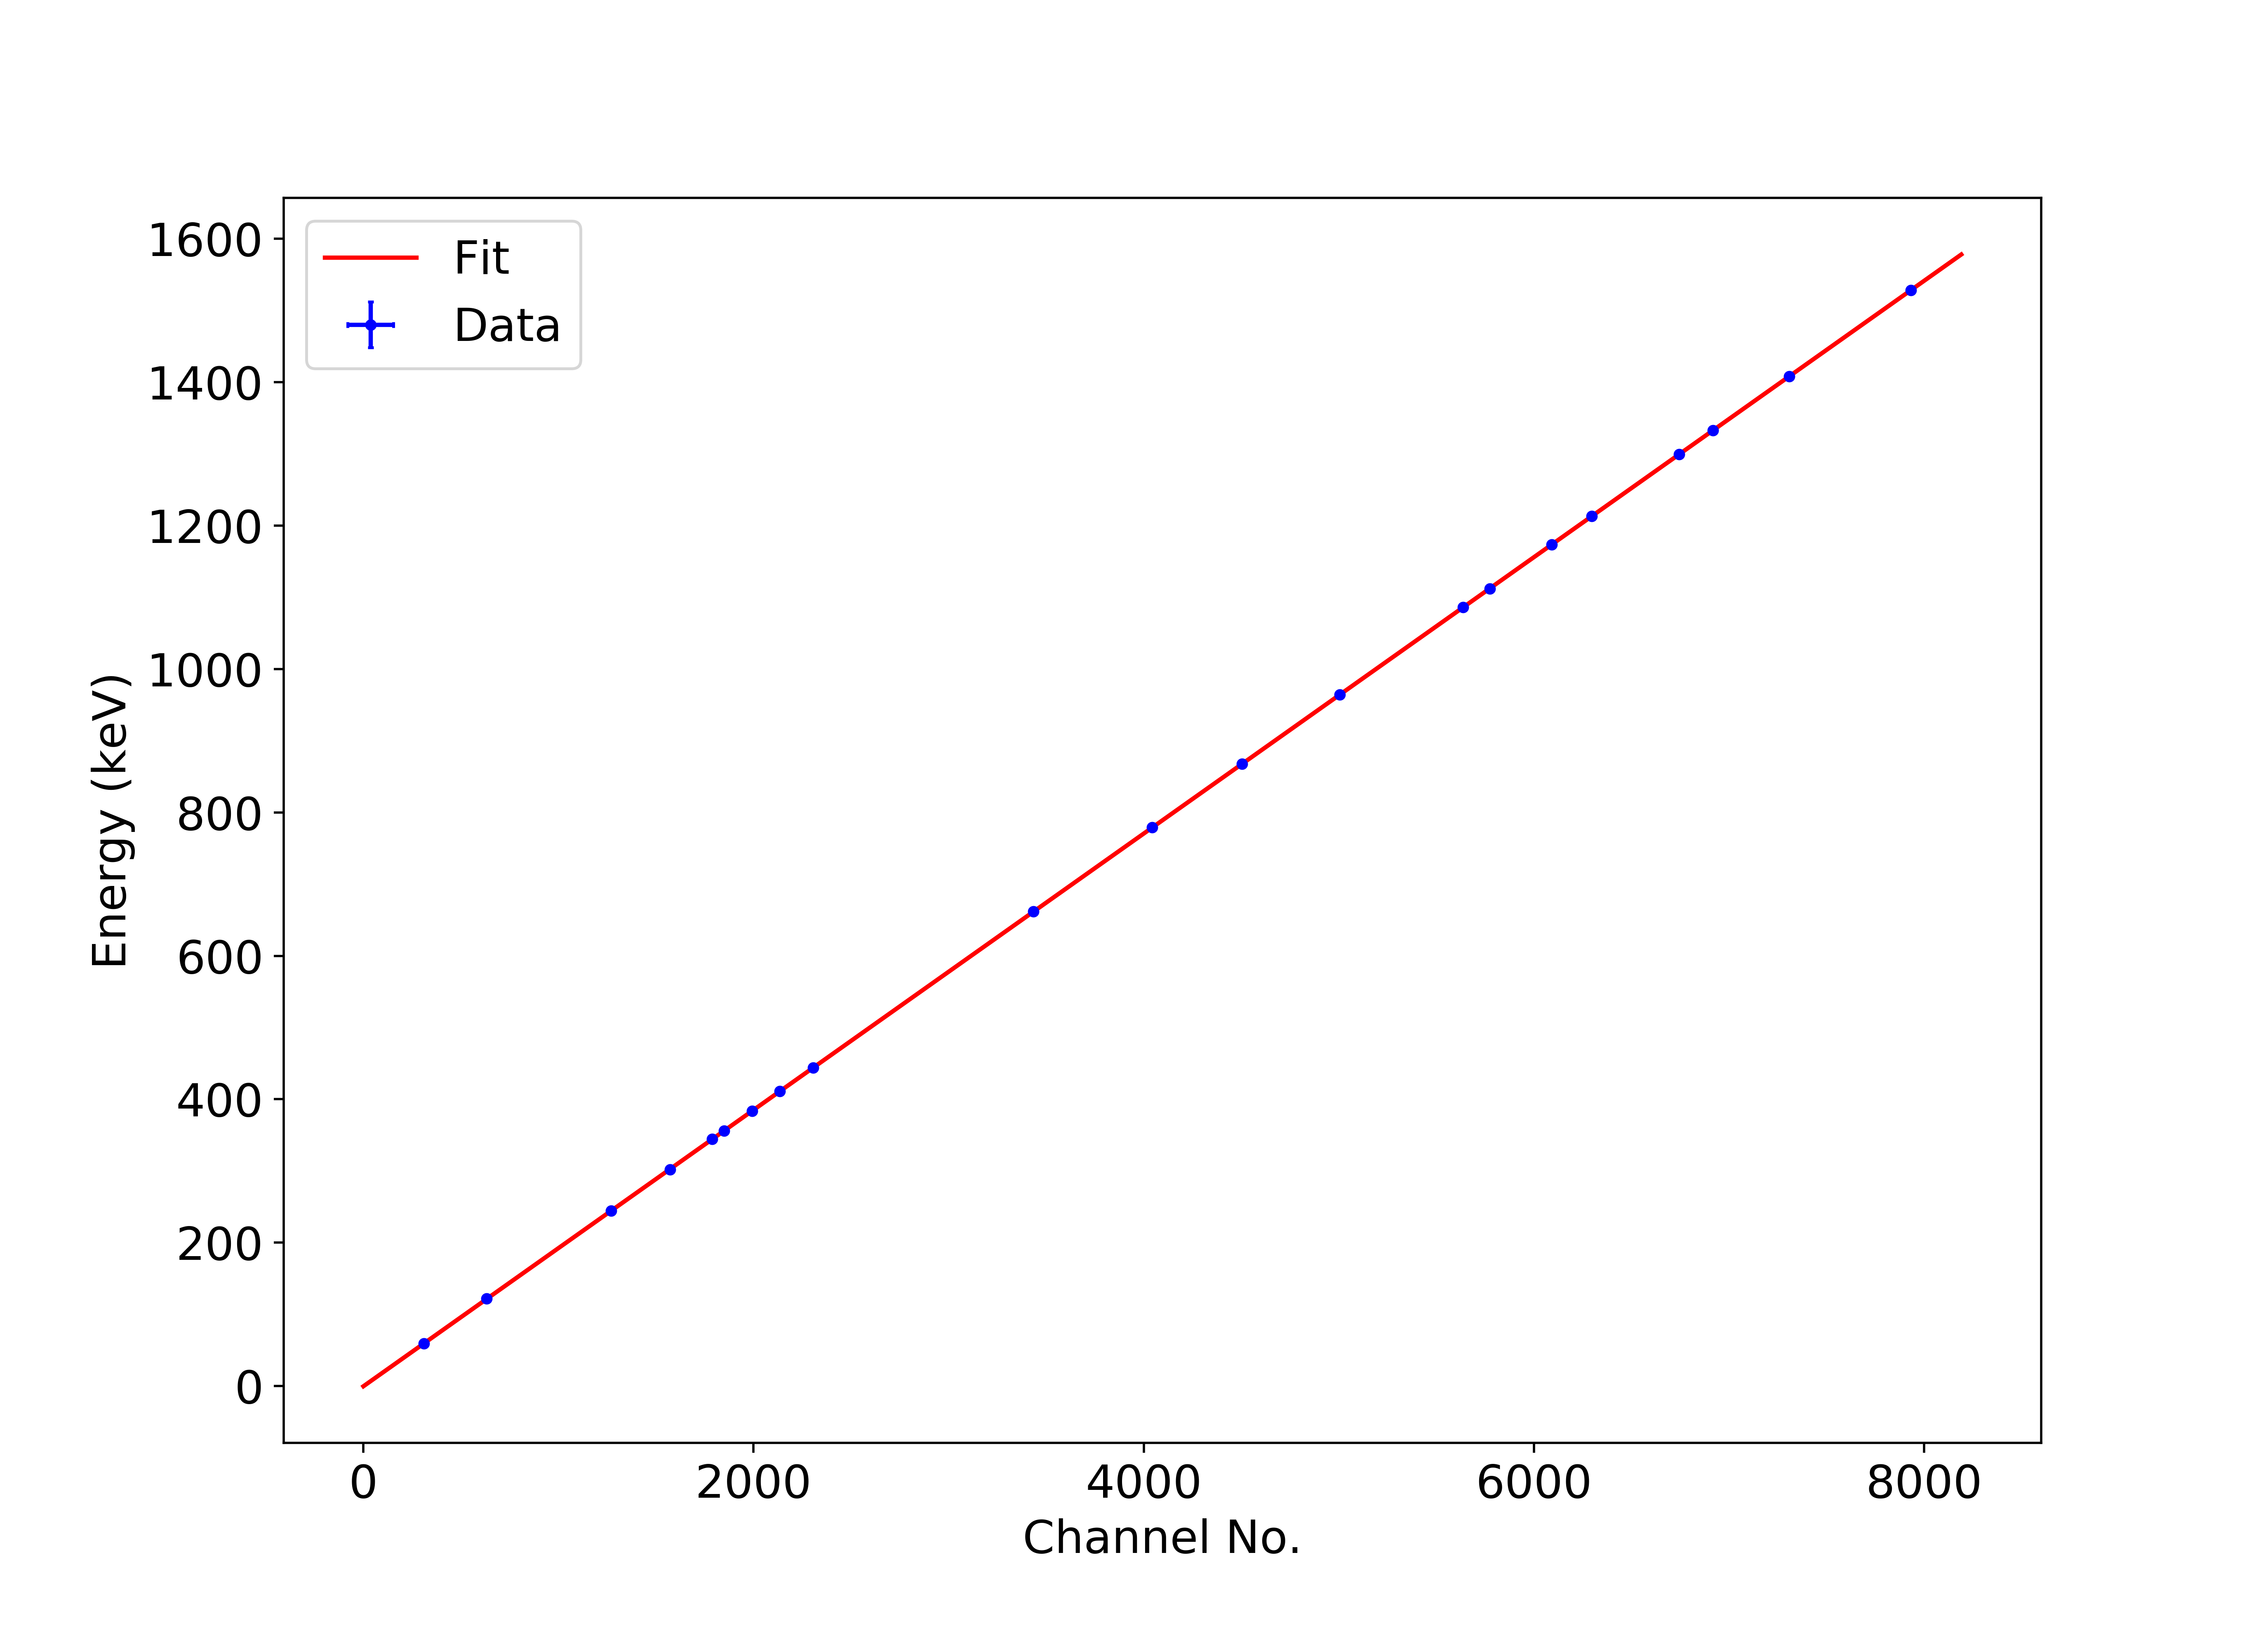

<Figure size 792x576 with 0 Axes>

In [8]:
#Plot the energy calibration
x_data = numpy.arange(0,8192)
y_data = energy_cal( x_data, *B_eng )
plt.plot( x_data, y_data, 'r', label='Fit' )
plt.errorbar( centroids, energies, xerr=centroids_unc, yerr=energies_unc, fmt='b.', capsize=1.0, label='Data' )
plt.xlabel('Channel No.')
plt.ylabel('Energy (keV)')
plt.legend()
plt.savefig('../images/energy_cal.png',dpi=500)
plt.savefig('../images/energy_cal.eps',format='eps')
plt.clf()
Image('../images/energy_cal.png')

Now obtain efficiency data points from the photopeak fits. The efficiency at a given gamma-ray energy, $E_{\gamma}$, is the ratio of the number of gamma-rays emitted by the source, $C_{exp}$, divided by the number of of gamma-rays detected, $C_{obs}$:

\begin{equation}
\varepsilon(E_{\gamma}) = \frac{C_{obs}}{C_{exp}}
\end{equation}

The number of gamma-rays emitted by the source, $C_{exp}$, can be calculated from the calibrated activity of the source: 

\begin{equation}
C_{exp} = I_{\gamma} R_{dead} \int_{t_0}^{t_1} A_0 e^{-\lambda t} dt
\end{equation}

\begin{equation}
C_{exp} = I_{\gamma} R_{dead} \times \Big[ -\frac{A_0 e^{-\lambda t}}{\lambda} \Big] _{t0}^{t1}
\end{equation}

\begin{equation}
C_{exp} = I_{\gamma} R_{dead} \frac{A_0}{\lambda} ( e^{-\lambda t_0} - e^{-\lambda t_1} )
\end{equation}

where $t_0$ is the time between the source calibration and the start of the count, $t_1$ is the time between the source calibration and the end of the count, $\lambda$ is the decay constant of the source, $A_0$ is the initial activity of the source at creation, $I_{\gamma}$ is the emission intensity of the gamma ray, and $R_{dead}$ is a dead time correction scalar.

Calculate $C_{exp}$ and its uncertainty using the general error propagation formula for each source:

In [9]:
#Half-lives
#                        152Eu        241Am     60Co        137Cs         133Ba
halflives     = [ 13.157*365.0, 432.6*365.0, 1925.28, 30.08*365.0, 10.551*365.0 ] #days
halflives_unc = [  0.009*365.0,   0.6*365.0,    0.14,  0.09*365.0,  0.011*365.0 ] #days
#Convert to seconds
for i in range(0,5):
    halflives[i] = halflives[i] * 24.0 * 60.0 * 60.0
    halflives_unc[i] = halflives_unc[i] * 24.0 * 60.0 * 60.0

    
#Start times
t0s     = [ 2493.15198, 3085.15198, 2050.15198, 2050.15198, 2493.15198 ] #days
#Convert to seconds
for i in range(0,5):
    t0s[i] = t0s[i] * 24.0 * 60.0 * 60.0


#End times
t1s = [] #seconds
for i in range(0,5):
    t1s.append( t0s[i] + 240369.0 )


#Dead time correction
R_dead = 240369.0 / 239378.0  #real time / live time


#Initial activities
#            152Eu   241Am    60Co   137Cs   133Ba
A0s     = [ 352720, 370000, 389200, 377400, 391100 ] #Bq
A0s_unc = [     40,   4000,    400,    400,    400 ] #Bq


#Gamma intensities
#                  241Am     152Eu     152Eu     133Ba     152Eu     133Ba     133Ba     152Eu     152Eu    137Cs     152Eu    152Eu    152Eu     152Eu     152Eu      60Co     152Eu     152Eu      60Co     152Eu    152Eu
#                59.5409  121.7817  244.6974  302.0129  344.2785  356.0192  383.8485  411.1165  443.9606  661.657  778.9045  867.380  964.057  1085.837  1112.076  1173.228  1212.948  1299.142  1332.492  1408.013  1528.10
intensities     = [ 35.9,    28.53,     7.55,    18.34,    26.59,    62.05,     8.94,    2.237,    2.827,   85.10,    12.93,    4.23,   14.51,    10.11,    13.67,    99.85,    1.415,    1.633,  99.9826,    20.87,   0.279 ]
intensities_unc = [  0.4,     0.16,     0.04,     0.13,     0.20,     0.0 ,     0.06,    0.013,    0.014,    0.20,     0.08,    0.03,    0.07,     0.05,     0.08,     0.03,    0.008,    0.011,   0.0006,     0.09,   0.003 ]
#Normalize
for i in range(0,len(windows)):
    intensities[i] = intensities[i] / 100.0
    intensities_unc[i] = intensities_unc[i] / 100.0


#Source No.
source_no       = [    1,        0,        0,        4,        0,        4,        4,        0,        0,       3,        0,       0,       0,        0,        0,        2,        0,        0,        2,        0,       0 ]


#Expected counts
C_exps = []
C_exps_unc = []
for i in range(0,len(windows)):
    C_exp = intensities[i] * R_dead * A0s[source_no[i]] / (ln(2.0)/halflives[source_no[i]]) * ( exp(-ln(2.0)/halflives[source_no[i]] * t0s[source_no[i]]) - exp(-ln(2.0)/halflives[source_no[i]] * t1s[source_no[i]]) )
    C_exp_unc = 0.0
    C_exp_unc += ( intensities_unc[i] * R_dead * A0s[source_no[i]] / (ln(2.0)/halflives[source_no[i]]) * ( exp(-ln(2.0)/halflives[source_no[i]] * t0s[source_no[i]]) - exp(-ln(2.0)/halflives[source_no[i]] * t1s[source_no[i]]) ) )**2.0
    C_exp_unc += ( A0s_unc[source_no[i]] * intensities[i] * R_dead / (ln(2.0)/halflives[source_no[i]]) * ( exp(-ln(2.0)/halflives[source_no[i]] * t0s[source_no[i]]) - exp(-ln(2.0)/halflives[source_no[i]] * t1s[source_no[i]]) ) )**2.0
    K = intensities[i] * R_dead * A0s[source_no[i]]
    y = ln(2.0)/halflives[source_no[i]]
    C_exp_unc += ( (halflives_unc[source_no[i]]/halflives[source_no[i]] * y) * K * ( (t1s[source_no[i]]*exp(-y*t1s[source_no[i]]) - t0s[source_no[i]]*exp(-y*t0s[source_no[i]]))/y - (exp(-y*t1s[source_no[i]]) - exp(-y*t0s[source_no[i]]))/y**2.0 ) )**2.0
    C_exp_unc = sqrt( C_exp_unc )
    C_exps.append( C_exp )
    C_exps_unc.append( C_exp_unc )

Now calculate the efficiencies:

In [10]:
efficiencies = []
efficiencies_unc = []
for i in range(0,len(windows)):
    efficiencies.append( nets[i] / C_exps[i] )
    efficiencies_unc.append( (nets[i] / C_exps[i]) * sqrt( (nets_unc[i]/nets[i])**2.0 + (C_exps_unc[i]/C_exps[i])**2.0 ) )

Demonstrate the fit obtained using a linear regression to the canonical logarithmic polynomial efficiency form:

\begin{equation}
\varepsilon(E_{\gamma}) = B_0 + B_1 ln(E_{\gamma}) + B_2 ln(E_{\gamma})^2 + B_3 ln(E_{\gamma})^3 + B_4 ln(E_{\gamma})^4
\end{equation}

Obtain a fit to all of the efficiency data points available:

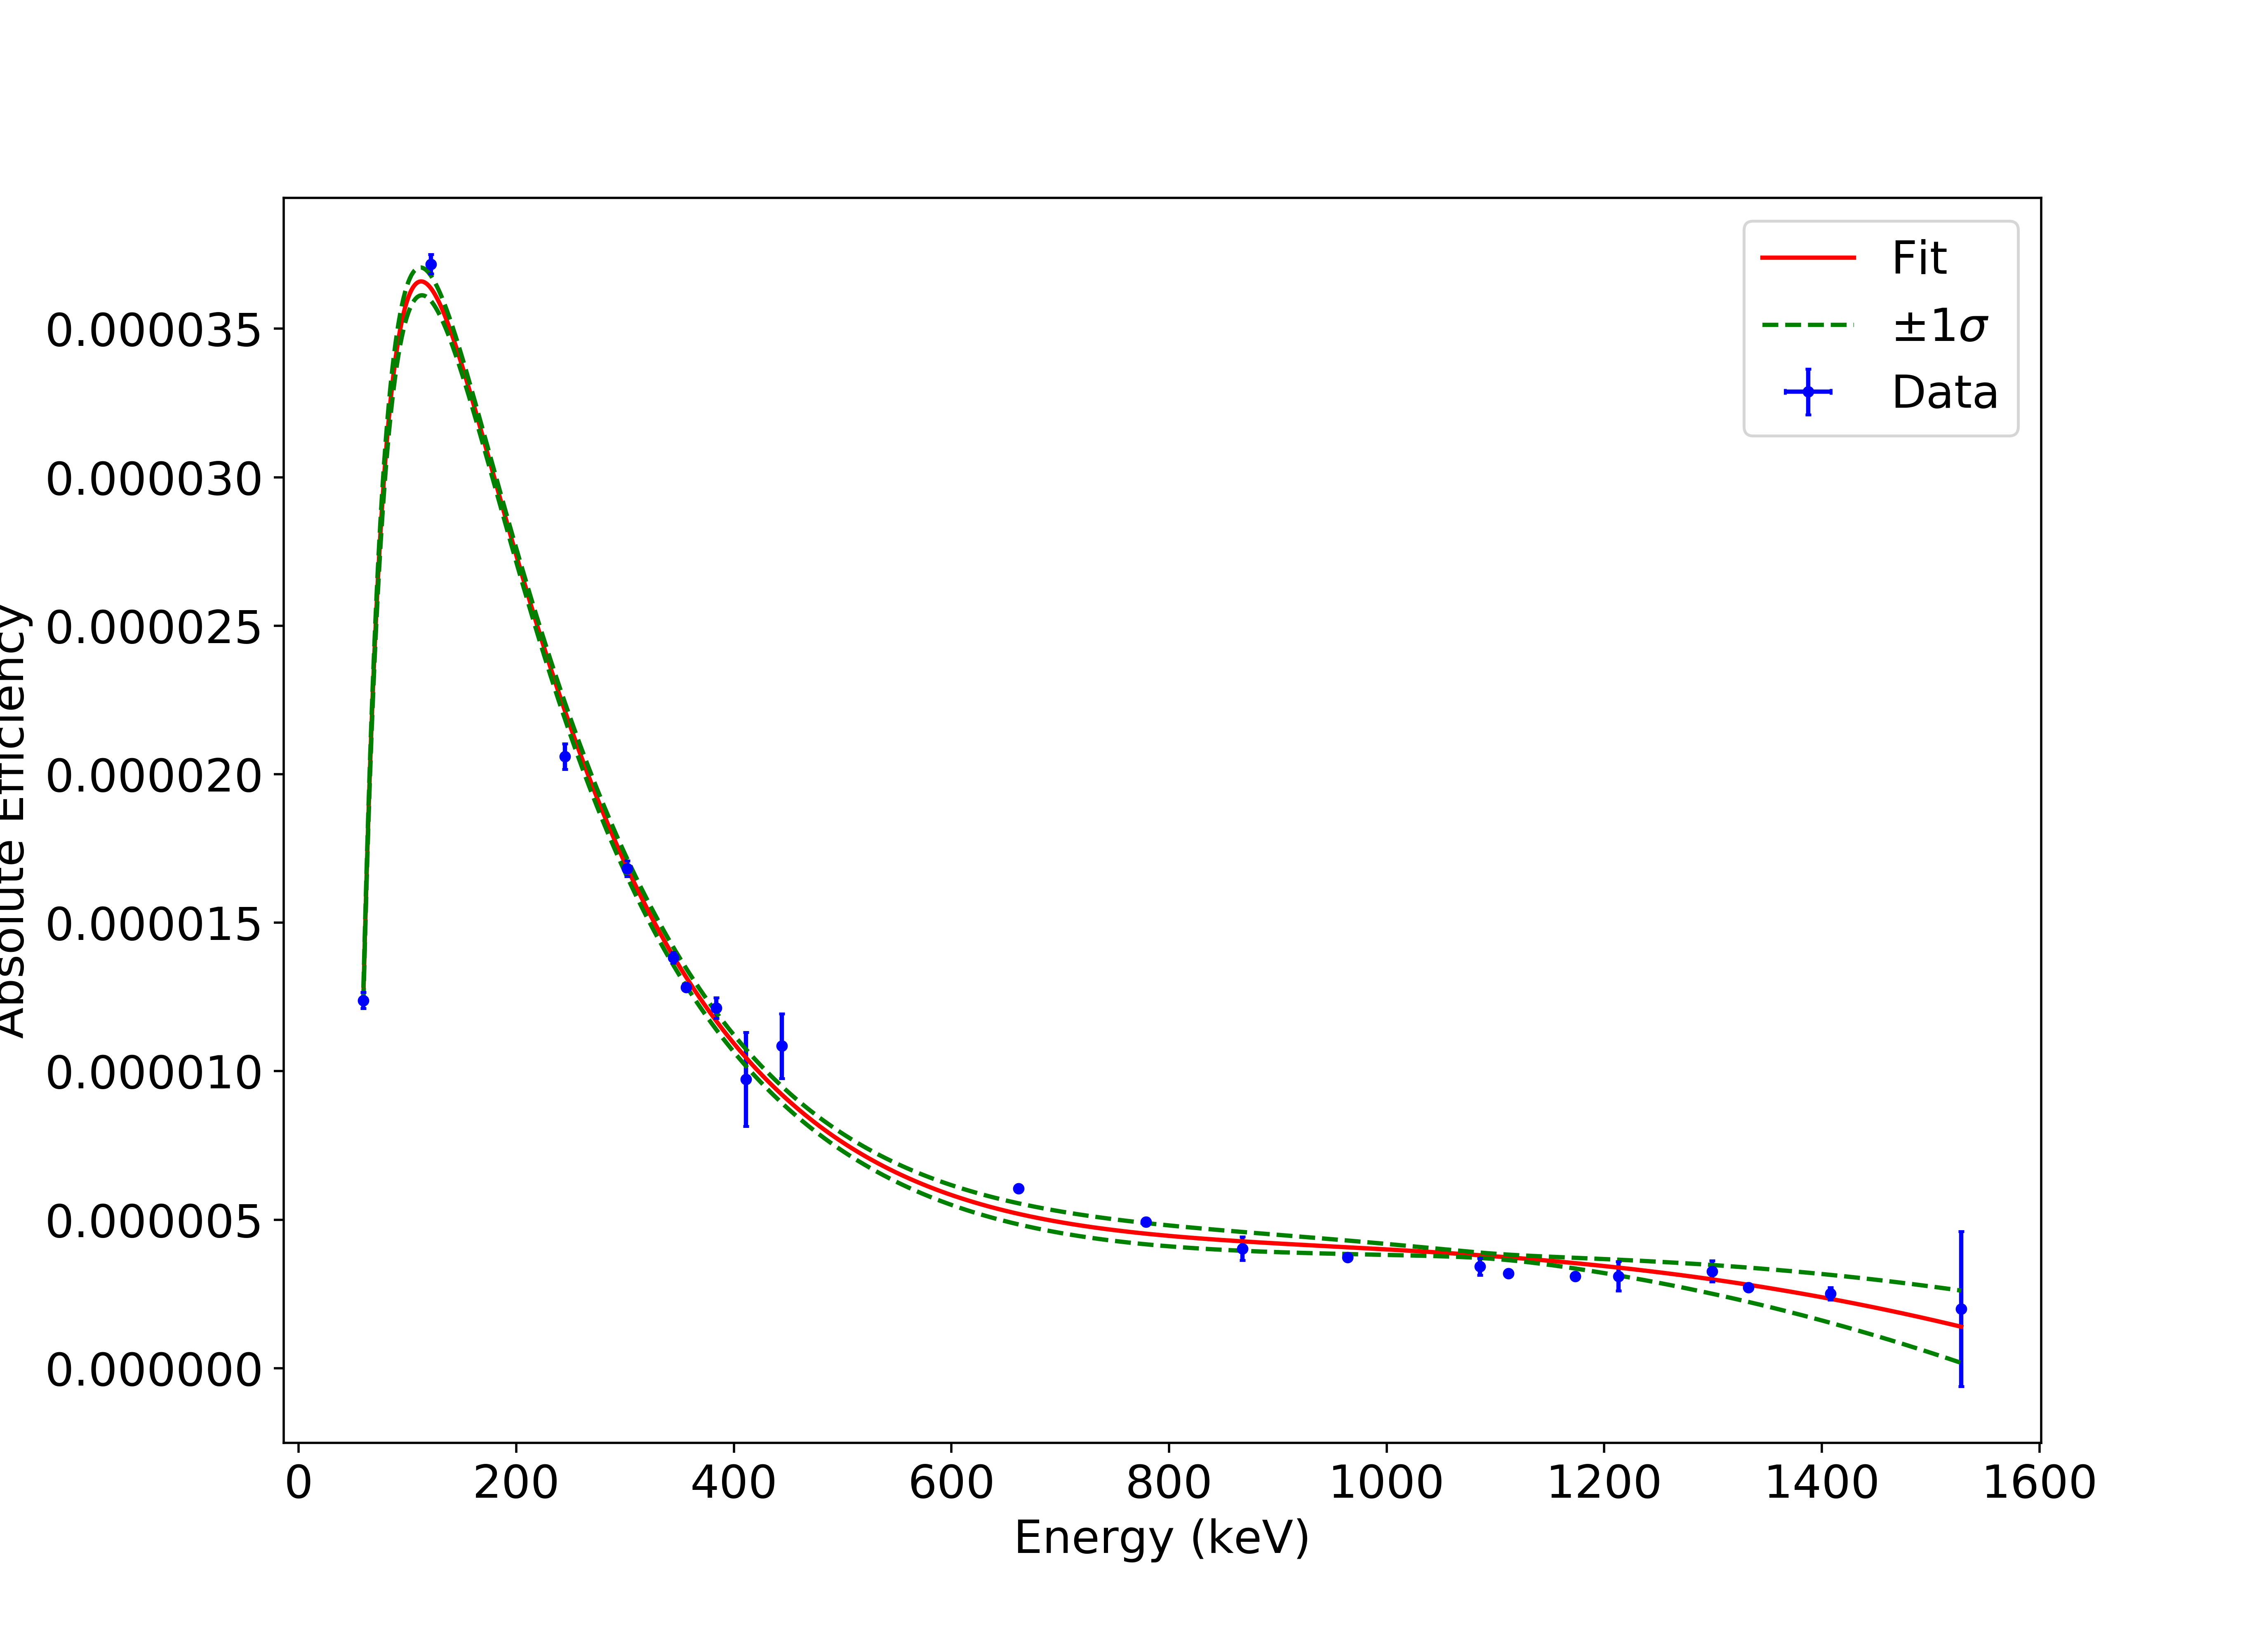

<Figure size 792x576 with 0 Axes>

In [11]:
#Obtain the logarithmic polynomial fit 
energies_log = numpy.log( energies )
B_poly = numpy.polyfit( energies_log, efficiencies, deg=4 )

#Obtain the covariance matrix from this fit by MC estimation
trials = 1000
trials_res_poly = numpy.zeros( (5,trials) )
for n in range(0,trials):
    energies_vard = numpy.random.normal( energies, energies_unc )
    energies_log_vard = numpy.log( energies_vard )
    efficiencies_vard = numpy.random.normal( efficiencies, efficiencies_unc )
    B_poly_vard = numpy.polyfit( energies_log_vard, efficiencies_vard, deg=4 )
    trials_res_poly[:,n] = B_poly_vard
B_poly_cov = numpy.cov( trials_res_poly )

#Report the fit to file
file = open('../fits/logpoly_eff.txt','w')
file.write('Fit:\n')
file.write( str(B_poly[0]) + ' ' + str(B_poly[1]) + ' ' + str(B_poly[2]) + ' ' + str(B_poly[3]) + ' ' + str(B_poly[4]) + '\n' )
file.write('\n')
file.write('Covariance Matrix: \n')
for p in range(0,5):
    for q in range(0,5):
        file.write( str(B_poly_cov[p,q]) + ' ' )
    file.write('\n')
file.close()

#Plot the fit
x_data = numpy.linspace( min(energies), max(energies), 1000 )
y_data = numpy.polyval( B_poly, numpy.log(x_data) )
y_data_err = logpoly_eff_MCerr( numpy.log(x_data), trials_res_poly )
y_data_err_top = y_data + y_data_err
y_data_err_bot = y_data - y_data_err
plt.plot( x_data, y_data, 'r', label='Fit' )
plt.plot( x_data, y_data_err_top, 'g--', label=r'$\pm 1 \sigma$' )
plt.plot( x_data, y_data_err_bot, 'g--' )
plt.errorbar( energies, efficiencies, xerr=energies_unc, yerr=efficiencies_unc, fmt='b.', capsize=1.0, label='Data' )
plt.xlabel('Energy (keV)')
plt.ylabel('Absolute Efficiency')
plt.legend()
plt.savefig( '../images/logpoly_eff.png', dpi=500 )
plt.savefig( '../images/logpoly_eff.eps', format='eps' )
plt.clf()
Image('../images/logpoly_eff.png')

Demonstrate the fit obtained using a physically informed model with the same number of fit parameters:

\begin{equation}
\varepsilon(E_{\gamma}) = B_0\, e^{-B_1 E_{\gamma}^{B_2}} (1 - e^{-B_3 E_{\gamma}^{B4}})
\end{equation}

where $B_0$ represents a geometric efficiency scalar, $(1 - e^{-B_3 E_{\gamma}^{B4}})$ represents the probability of the gamma-ray penetrating the detector dead layer, $e^{-B_1 E_{\gamma}^{B_2}}$ represents the probability of interaction inside the detector volume, and $B_1 E_{\gamma}^{B_2}$ and $B_3 E_{\gamma}^{B4}$ represent the energy-dependent attenuation coefficient of the detector and dead layer, respectively.

Obtain a fit to all of the efficiency data points available (this covariance analysis requires a fair amount of computational power, toggle `rerun2` to force the analysis to run):

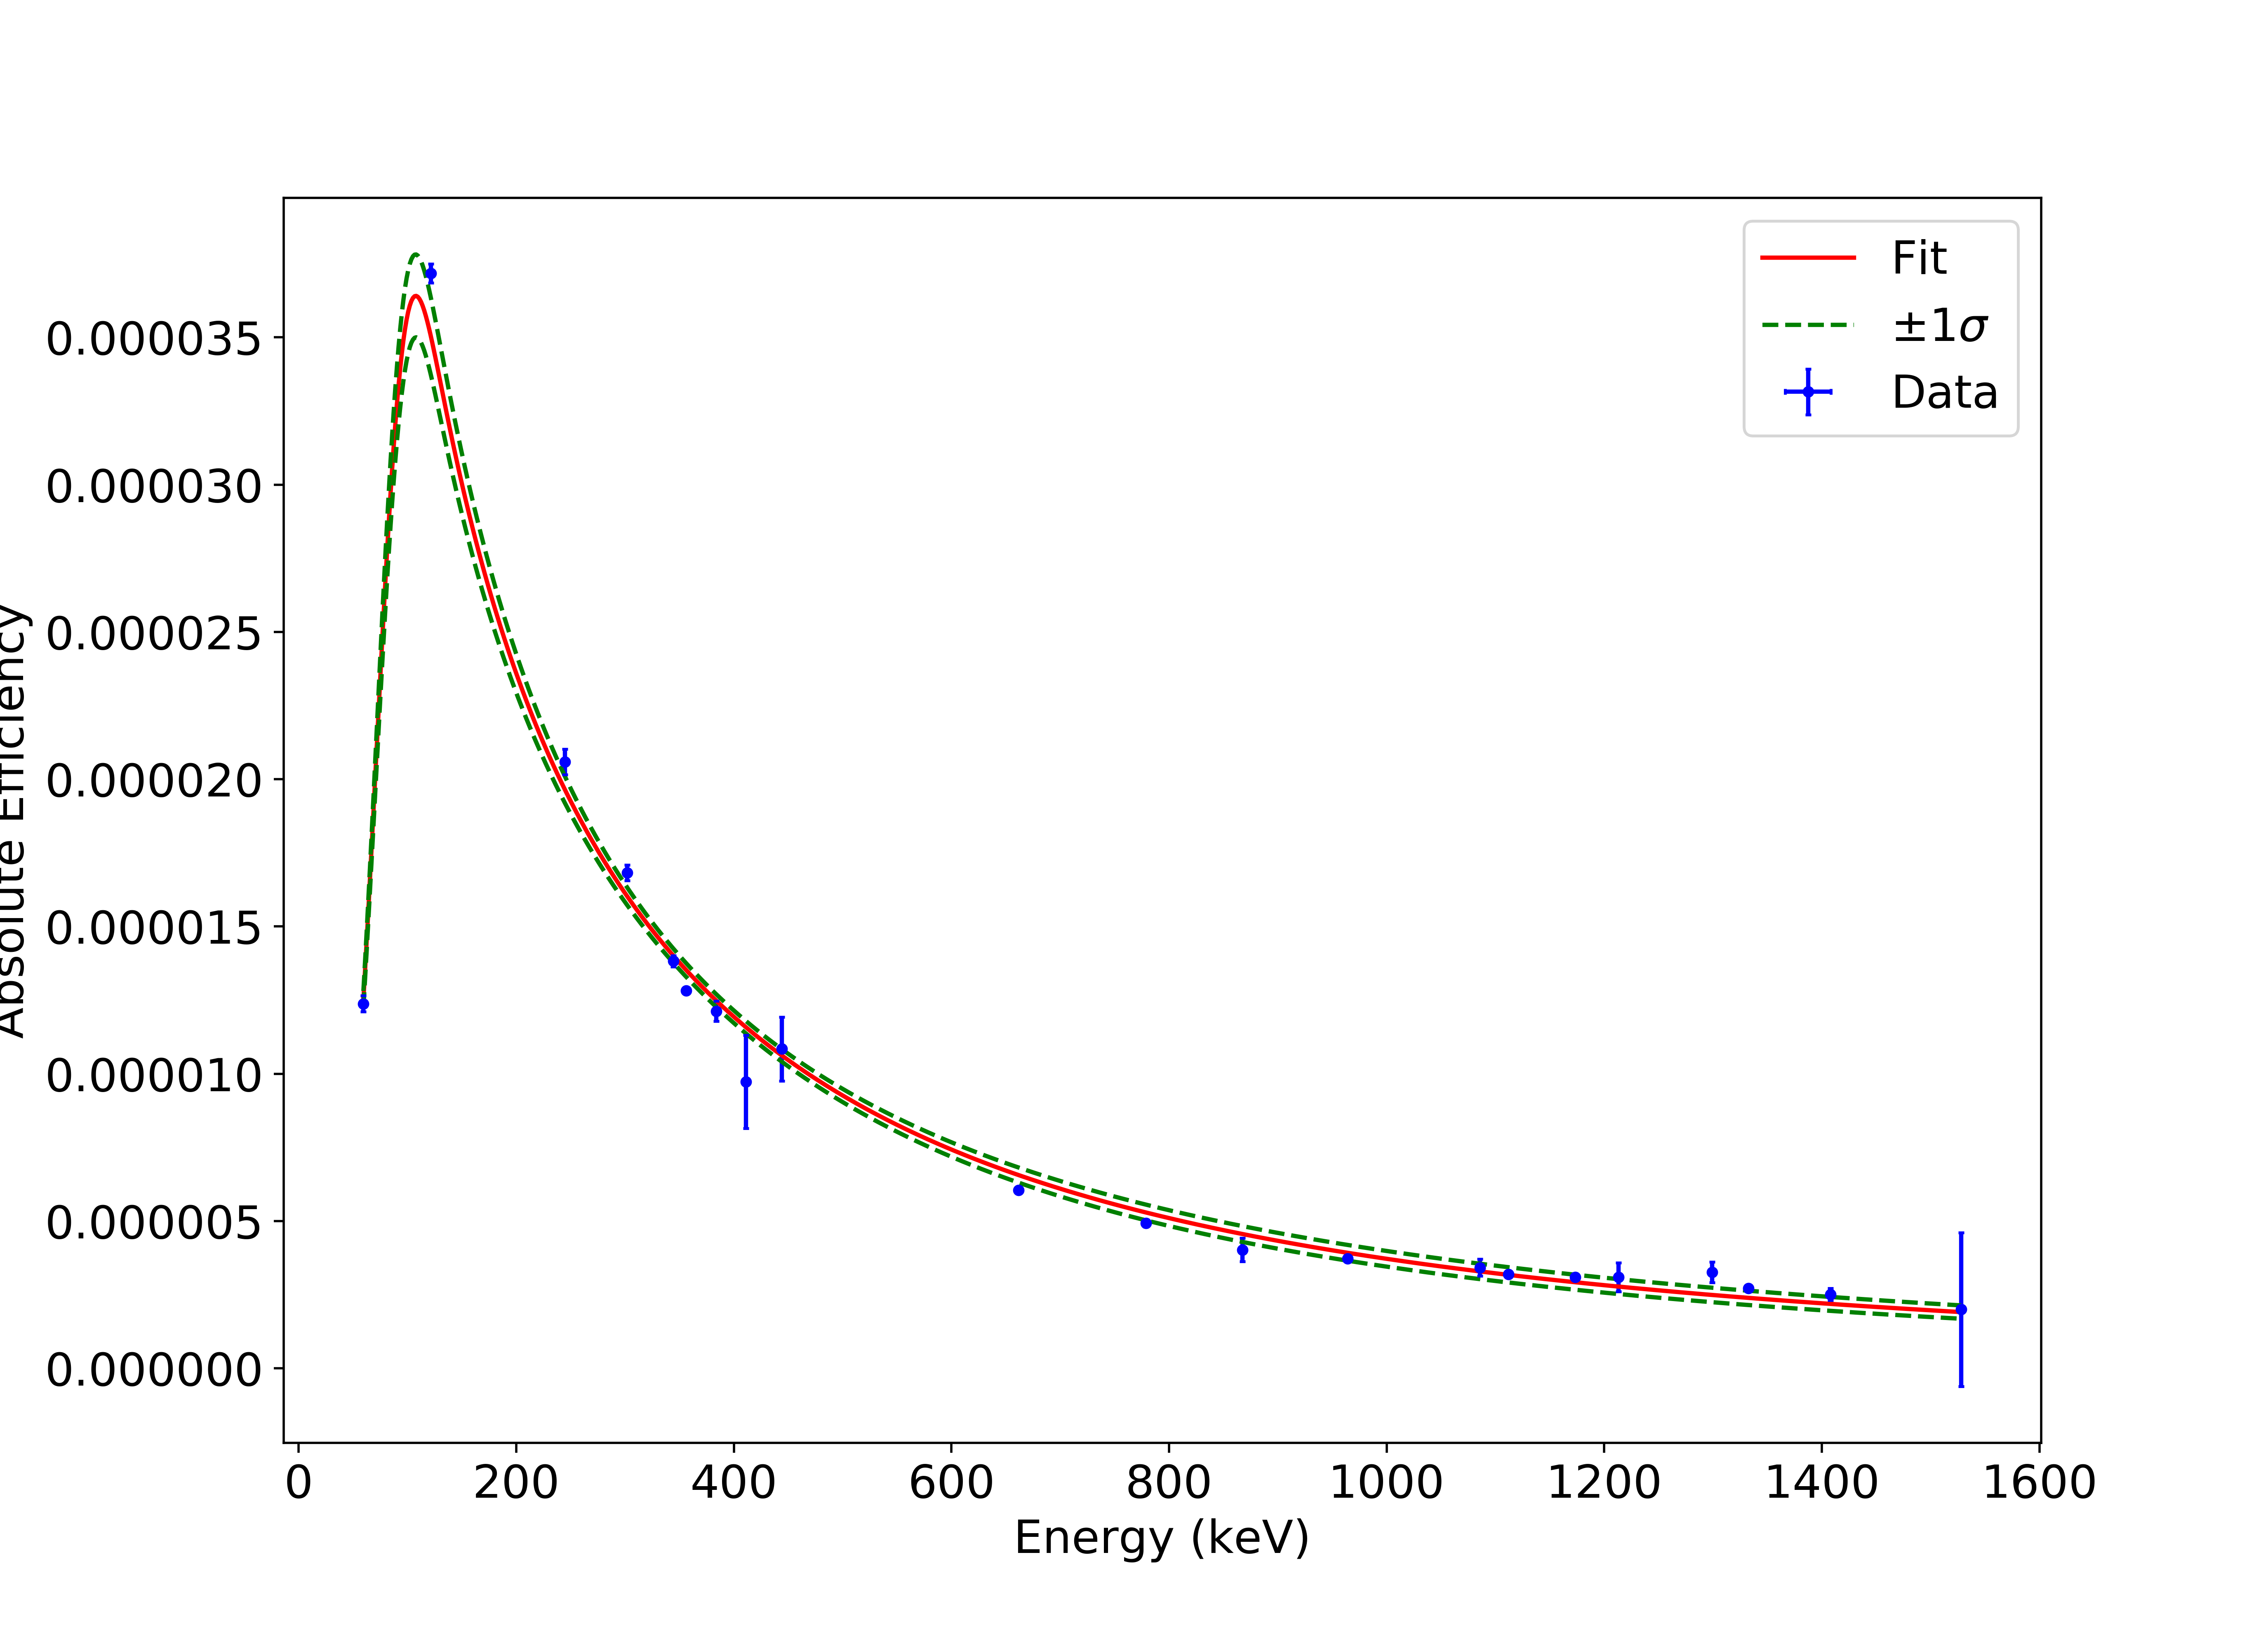

<Figure size 792x576 with 0 Axes>

In [12]:
rerun2 = False #Toggle this to force fitting

if( rerun2 or (not('phys_eff1.txt' in os.listdir('../fits'))) ):
    #Obtain the fit
    B_phys = physical_eff1_fit( energies, efficiencies )

    #Obtain the covariance matrix from this fit by MC estimation
    trials = 1000
    trials_res_phys = numpy.zeros( (5,trials) )
    for n in range(0,trials):
        energies_vard = numpy.random.normal( energies, energies_unc )
        efficiencies_vard = numpy.random.normal( efficiencies, efficiencies_unc )
        B_phys_vard = physical_eff1_fit( energies_vard, efficiencies_vard )
        
        #Reject outliers
        #Assess outliers on a rolling basis after first 10 fits
        if( n >= 10 ):
            mean = numpy.mean(trials_res_phys[:,0:n],axis=1)
            std = numpy.std(trials_res_phys[:,0:n],axis=1)
            while( numpy.any( abs(numpy.array(B_phys_vard)-mean) >= 3*std ) ):
                energies_vard = numpy.random.normal( energies, energies_unc )
                efficiencies_vard = numpy.random.normal( efficiencies, efficiencies_unc )
                B_phys_vard = physical_eff1_fit( energies_vard, efficiencies_vard )
        
        trials_res_phys[:,n] = B_phys_vard
    
    B_phys_cov = numpy.cov( trials_res_phys )
    
    #Pickle the trial results
    file = open('../fits/trials_res_phys.pkl','wb')
    pickle.dump( trials_res_phys, file )
    file.close()

    #Report the fit to file
    file = open('../fits/phys_eff1.txt','w')
    file.write('Fit:\n')
    file.write( str(B_phys[0]) + ' ' + str(B_phys[1]) + ' ' + str(B_phys[2]) + ' ' + str(B_phys[3]) + ' ' + str(B_phys[4]) + '\n' )
    file.write('\n')
    file.write('Covariance Matrix: \n')
    for p in range(0,5):
        for q in range(0,5):
            file.write( str(B_phys_cov[p,q]) + ' ' )
        file.write('\n')
    file.close()

else:
    file = open('../fits/phys_eff1.txt','r')
    lines = file.readlines()
    file.close()
    B_phys = [ float(i) for i in lines[1].split() ]
    B_phys_cov = numpy.zeros( (5,5) )
    for p in range(0,5):
        for q in range(0,5):
            B_phys_cov[p,q] = float( lines[4+p].split()[q] )
    
    file = open('../fits/trials_res_phys.pkl','rb')
    trials_res_phys = pickle.load( file )
    file.close()

#Plot the fit
x_data = numpy.linspace( min(energies), max(energies), 1000 )
y_data = physical_eff1( x_data, *B_phys )
y_data_err = physical_eff1_MCerr( x_data, trials_res_phys )
y_data_err_top = y_data + y_data_err
y_data_err_bot = y_data - y_data_err
plt.plot( x_data, y_data, 'r', label='Fit' )
plt.plot( x_data, y_data_err_top, 'g--', label=r'$\pm 1 \sigma$' )
plt.plot( x_data, y_data_err_bot, 'g--' )
plt.errorbar( energies, efficiencies, xerr=energies_unc, yerr=efficiencies_unc, fmt='b.', capsize=1.0, label='Data' )
plt.xlabel('Energy (keV)')
plt.ylabel('Absolute Efficiency')
plt.legend()
plt.savefig( '../images/phys_eff1.png', dpi=500 )
plt.savefig( '../images/phys_eff1.eps', format='eps' )
plt.clf()
Image('../images/phys_eff1.png')

An aside on uncertainty propagation:

Neither of the logarithmic polynomial, nor the above physically informed efficiency model are able to have uncertainties propagated from their covariance matrices with the general error propagation formula. 

This is because the general error propagation formula is a linear approximation of error propagation. It fails to properly describe the error propagation through rapidly changing functions or functions with rapidly changing first derivatives. The logarithmic polynomial features $ln(E_{\gamma})^2$, $ln(E_{\gamma})^3$, $ln(E_{\gamma})^4$ terms and the physically informed model contains exponential terms, making both evolve rapidly with respect to $E_{\gamma}$. 

Below are plots of the $\pm 1 \sigma$ uncertainty bands calculated for the two above fits using the general error propagation formula. It is apparent that the error propagation formula fails to accurately describe the uncertainty in the fits. As much Monte-Carlo uncertainty estimation (as performed aboved) or higher order error propagation techniques must be used. 

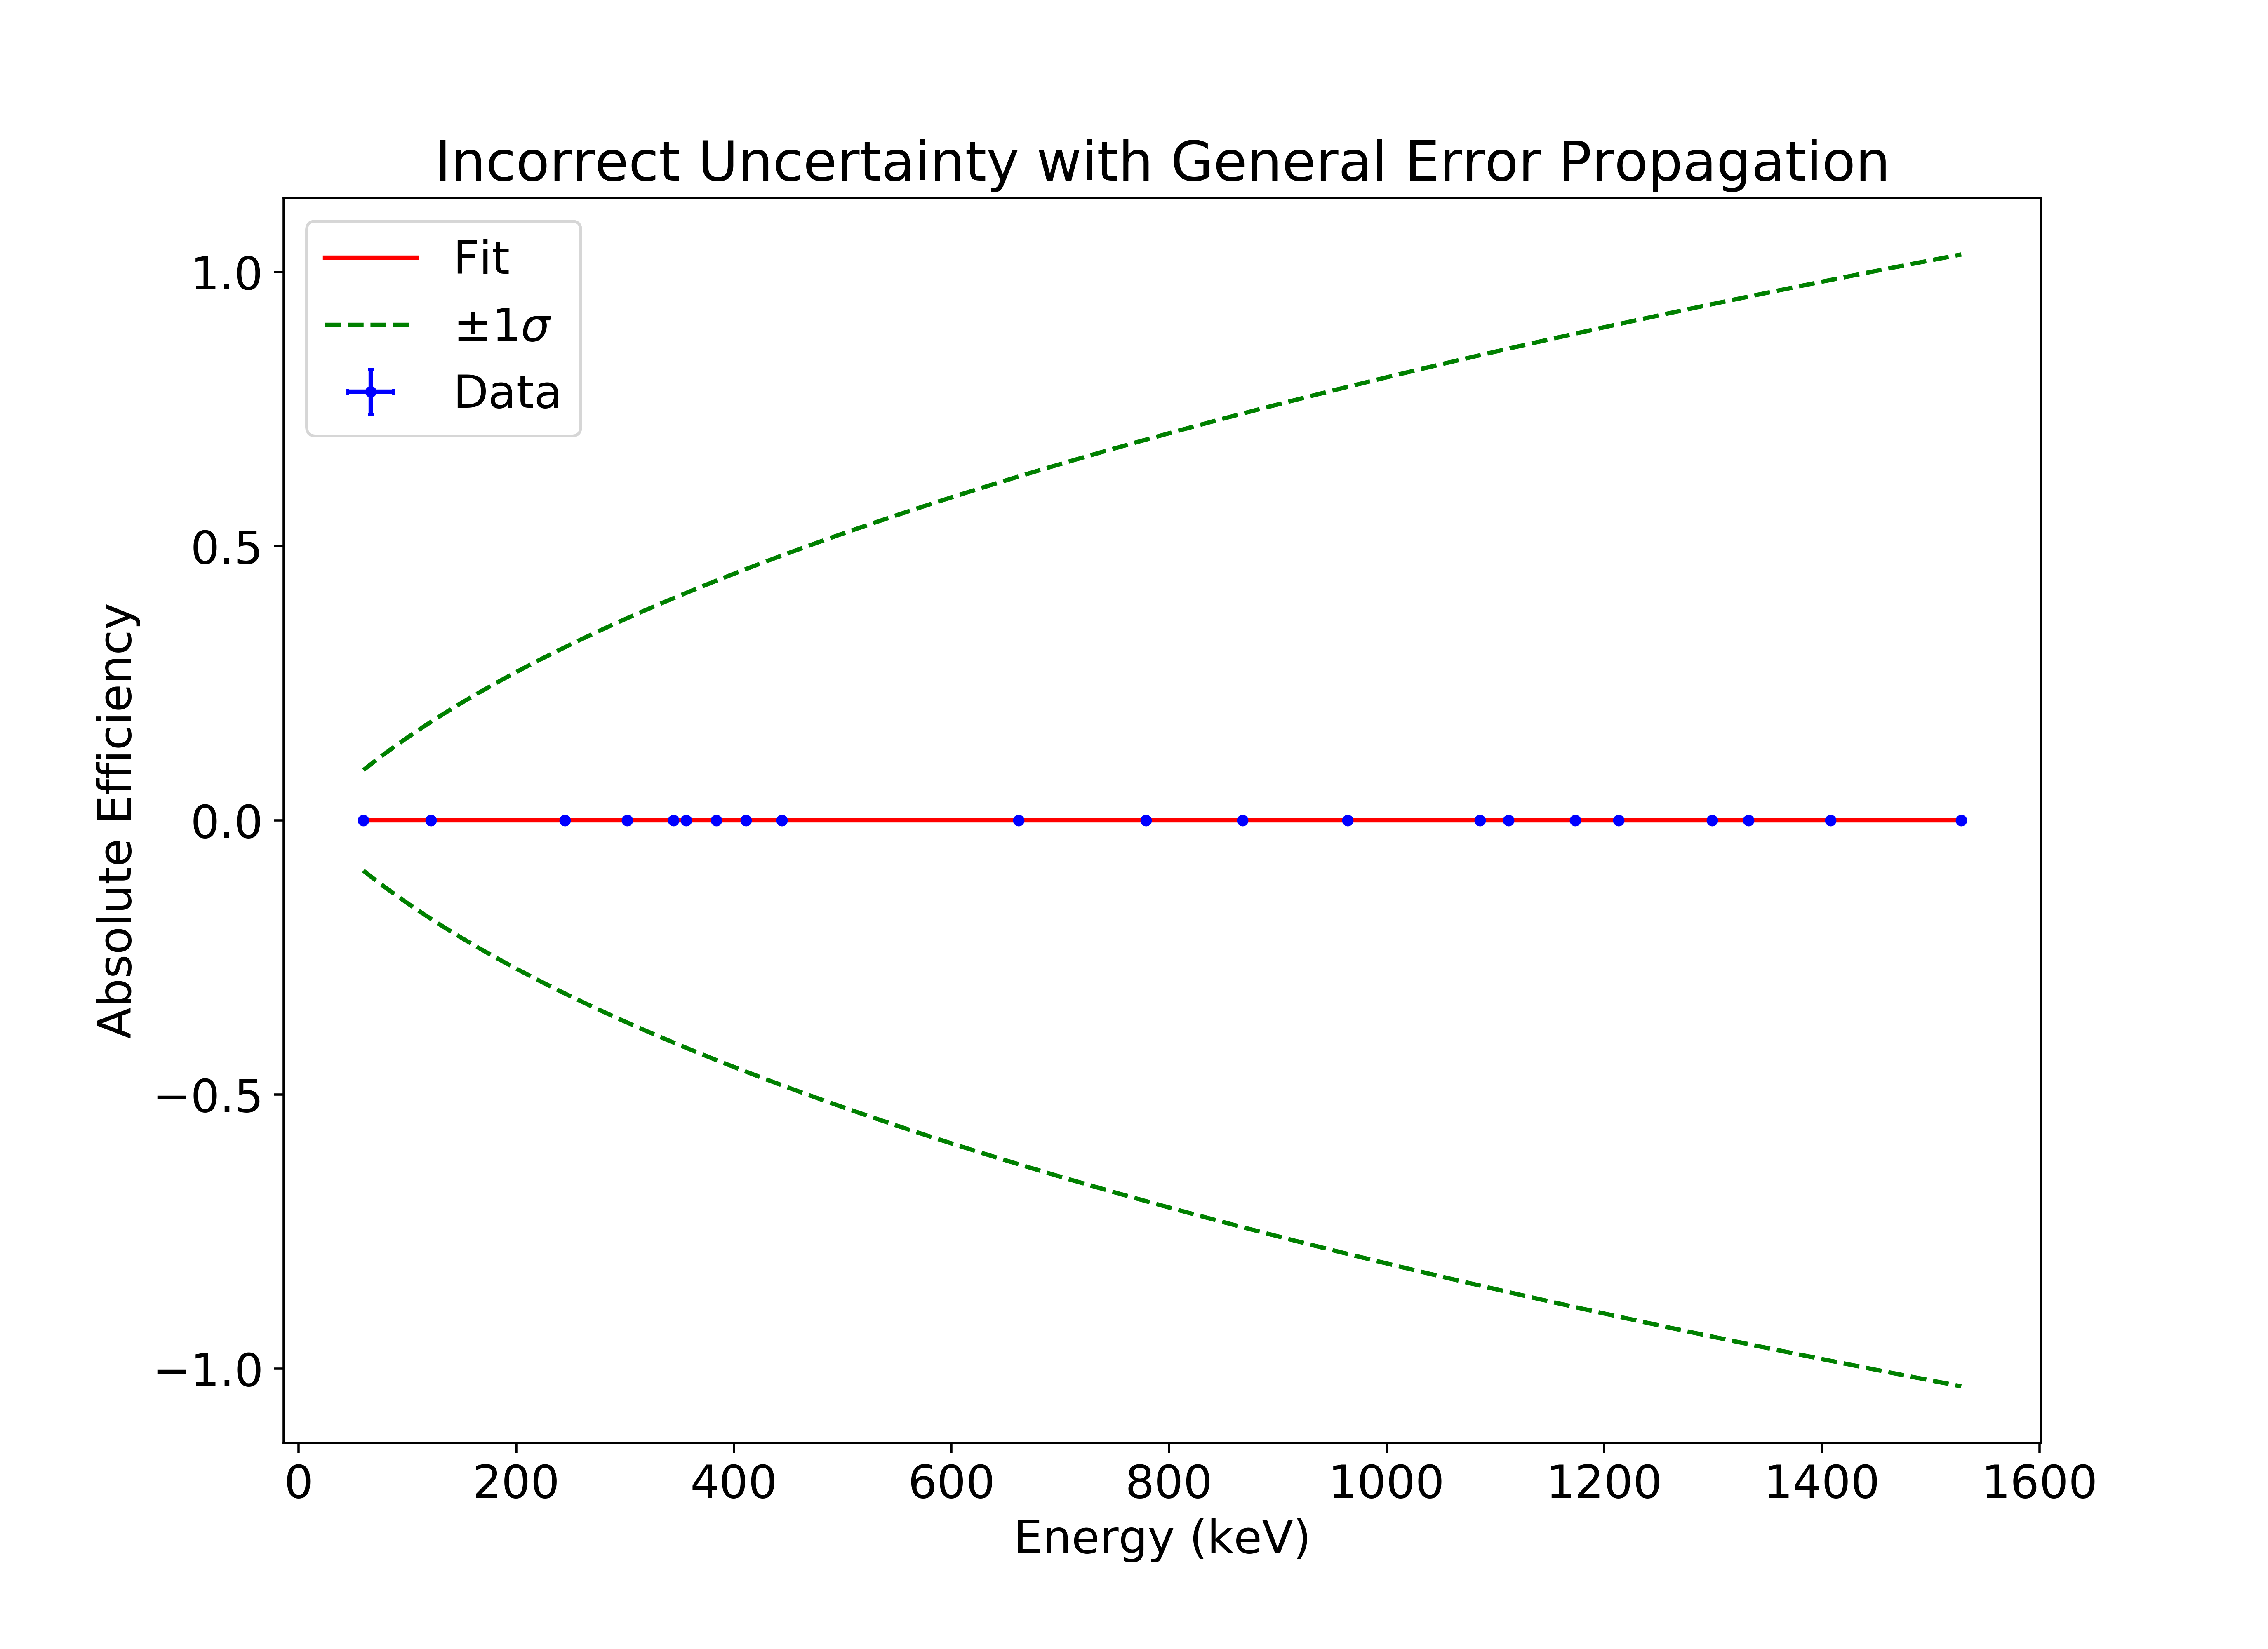

<Figure size 792x576 with 0 Axes>

In [13]:
#Plot the fit
x_data = numpy.linspace( min(energies), max(energies), 1000 )
y_data = numpy.polyval( B_poly, numpy.log(x_data) )
y_data_err = logpoly_eff_err( numpy.log(x_data), B_poly_cov )
y_data_err_top = y_data + y_data_err
y_data_err_bot = y_data - y_data_err
plt.plot( x_data, y_data, 'r', label='Fit' )
plt.plot( x_data, y_data_err_top, 'g--', label=r'$\pm 1 \sigma$' )
plt.plot( x_data, y_data_err_bot, 'g--' )
plt.errorbar( energies, efficiencies, xerr=energies_unc, yerr=efficiencies_unc, fmt='b.', capsize=1.0, label='Data' )
plt.xlabel('Energy (keV)')
plt.ylabel('Absolute Efficiency')
plt.title('Incorrect Uncertainty with General Error Propagation')
plt.legend()
plt.savefig( '../images/logpoly_eff_wrong_unc.png', dpi=500 )
plt.clf()
Image('../images/logpoly_eff_wrong_unc.png')

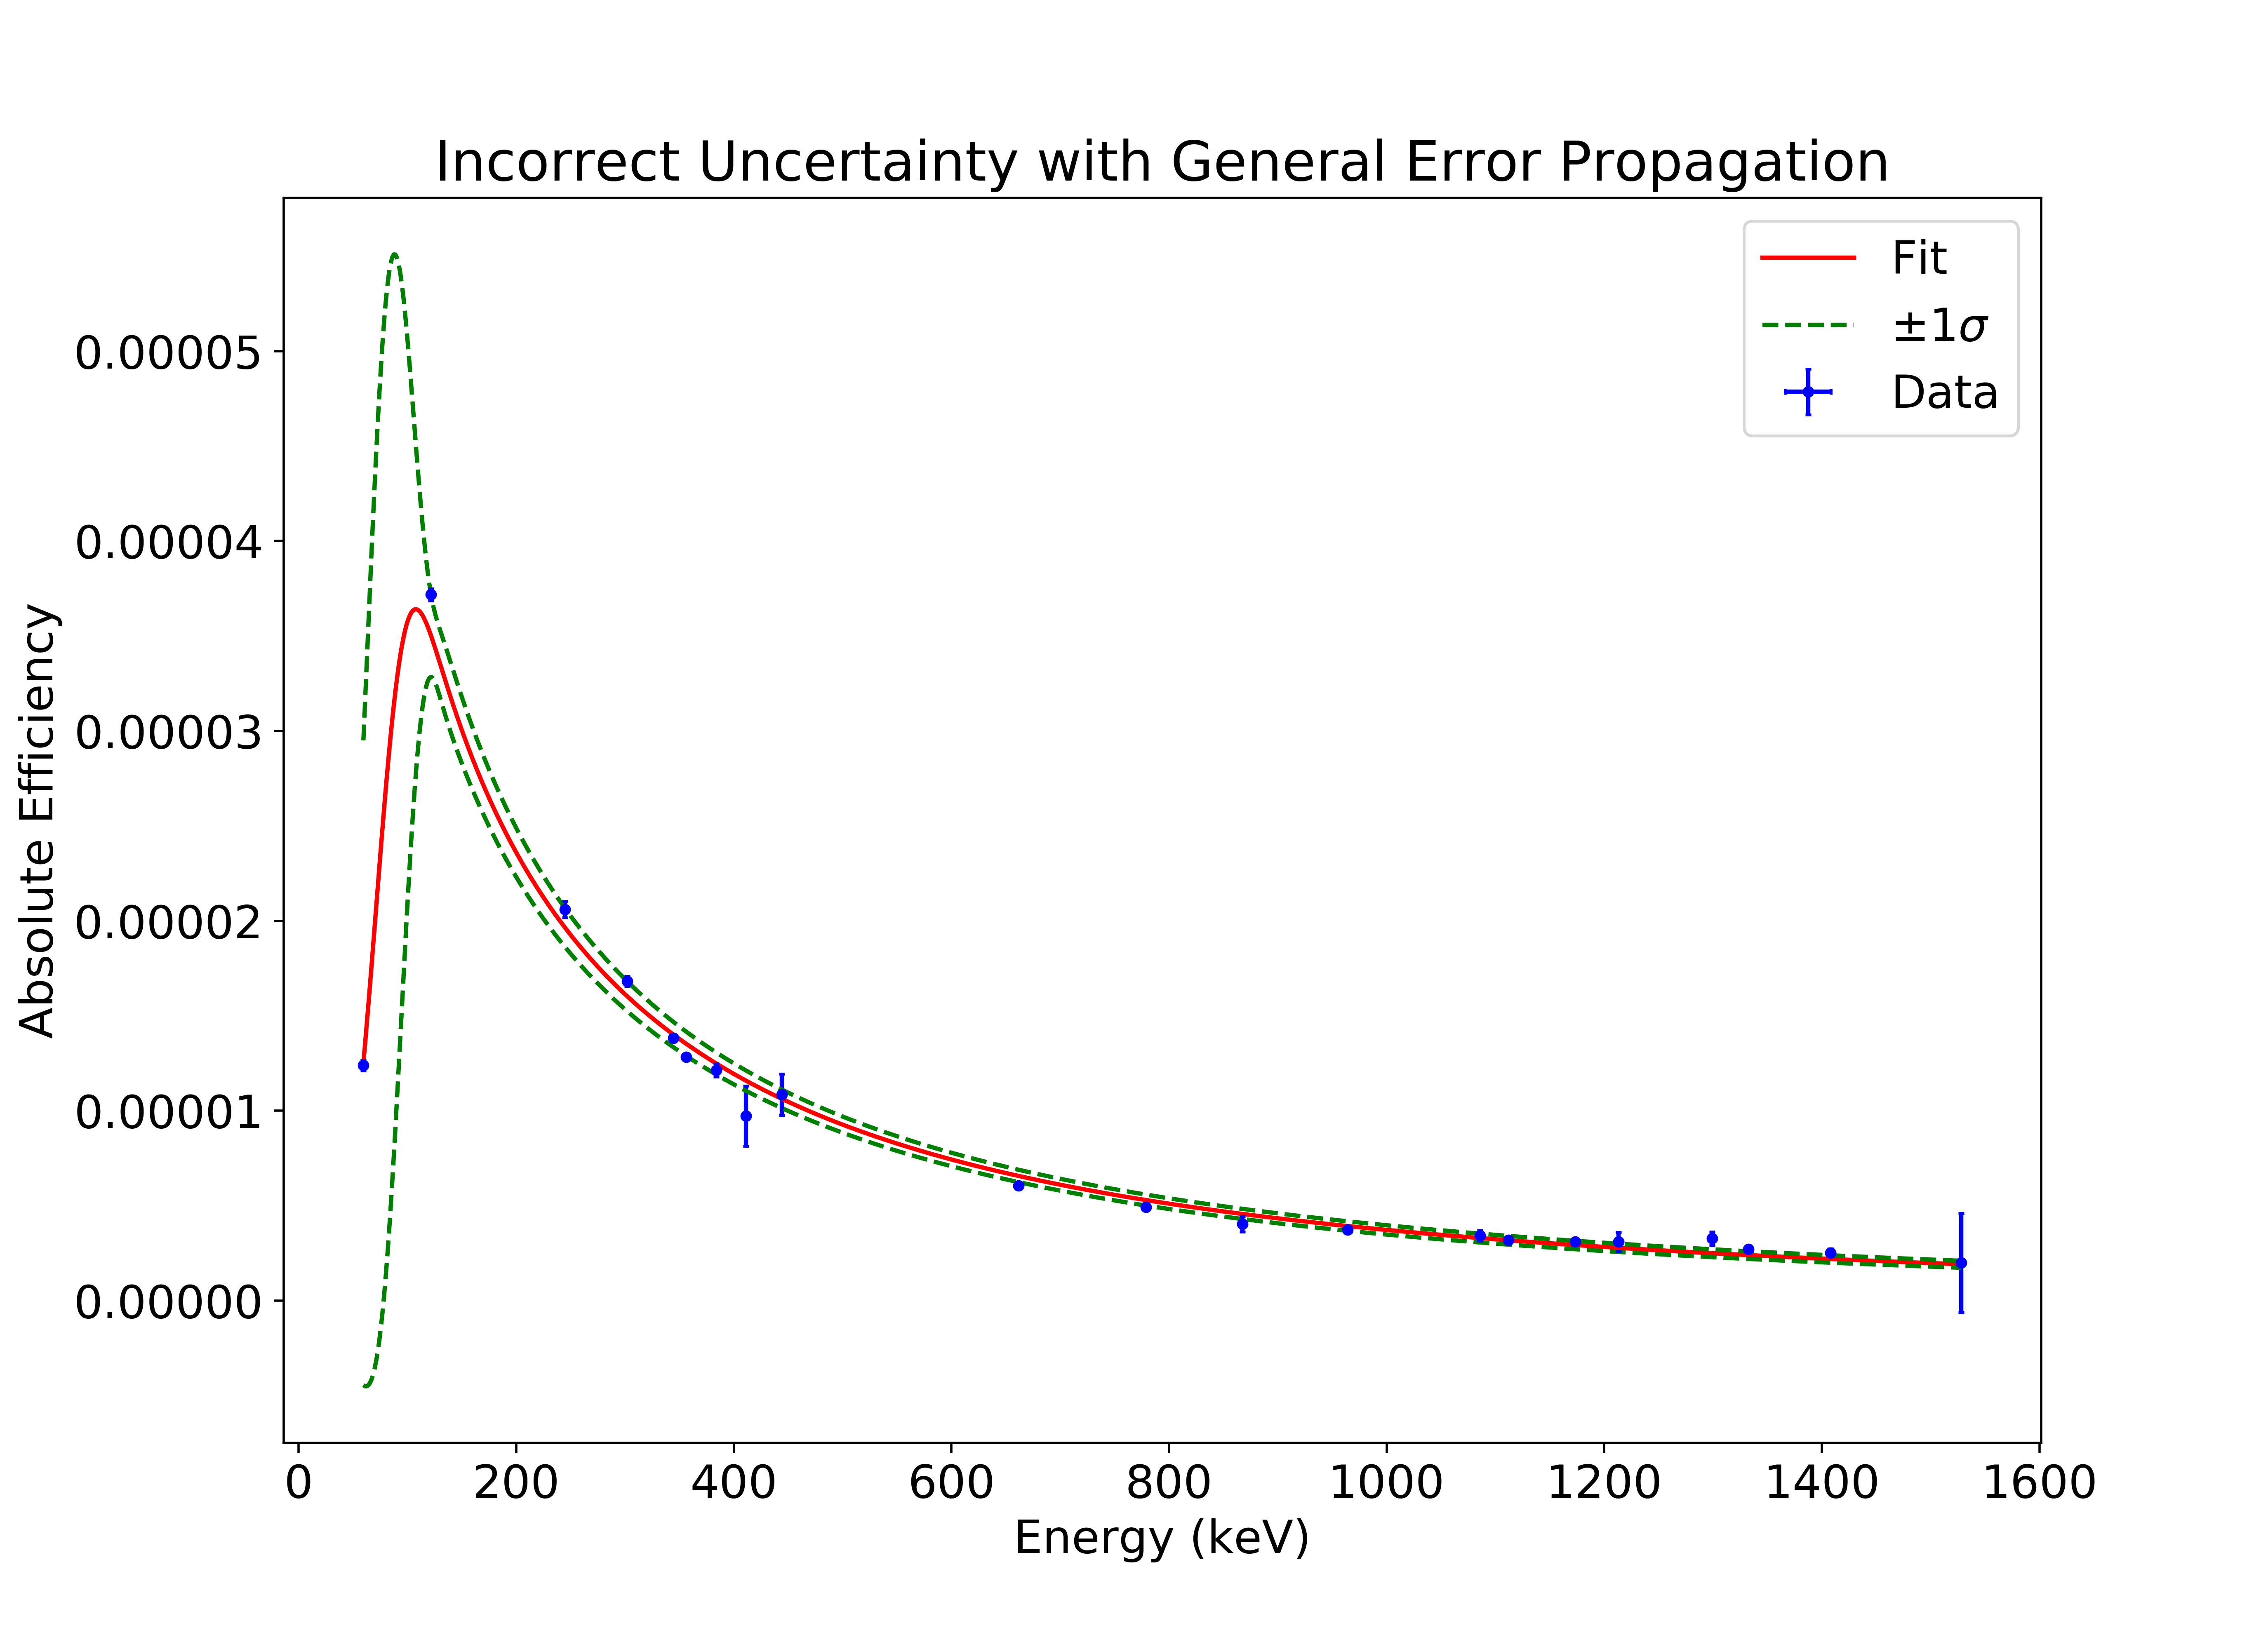

<Figure size 792x576 with 0 Axes>

In [14]:
#Plot the fit
x_data = numpy.linspace( min(energies), max(energies), 1000 )
y_data = physical_eff1( x_data, *B_phys )
y_data_err = physical_eff1_err( x_data, B_phys, B_phys_cov )
y_data_err_top = y_data + y_data_err
y_data_err_bot = y_data - y_data_err
plt.plot( x_data, y_data, 'r', label='Fit' )
plt.plot( x_data, y_data_err_top, 'g--', label=r'$\pm 1 \sigma$' )
plt.plot( x_data, y_data_err_bot, 'g--' )
plt.errorbar( energies, efficiencies, xerr=energies_unc, yerr=efficiencies_unc, fmt='b.', capsize=1.0, label='Data' )
plt.xlabel('Energy (keV)')
plt.ylabel('Absolute Efficiency')
plt.title('Incorrect Uncertainty with General Error Propagation')
plt.legend()
plt.savefig( '../images/phys_eff1_wrong_unc.png', dpi=500 )
plt.clf()
Image('../images/phys_eff1_wrong_unc.png')

Calculate the chi-square value for each fit:

In [15]:
pred_poly = numpy.polyval( B_poly, numpy.log(energies) )
chi2_poly = scipy.stats.chisquare( pred_poly, f_exp=efficiencies )[0]
print( 'Chi-squared value for logpoly fit = ' + str(chi2_poly) )

pred_phys = physical_eff1( numpy.array(energies), *B_phys )
chi2_phys = scipy.stats.chisquare( pred_phys, f_exp=efficiencies )[0]
print( 'Chi-squared value for physical fit = ' + str(chi2_phys) )

Chi-squared value for logpoly fit = 1.104034502646217e-06
Chi-squared value for physical fit = 1.0887330250194139e-06


Assess and plot the absolute percent difference between the two models:

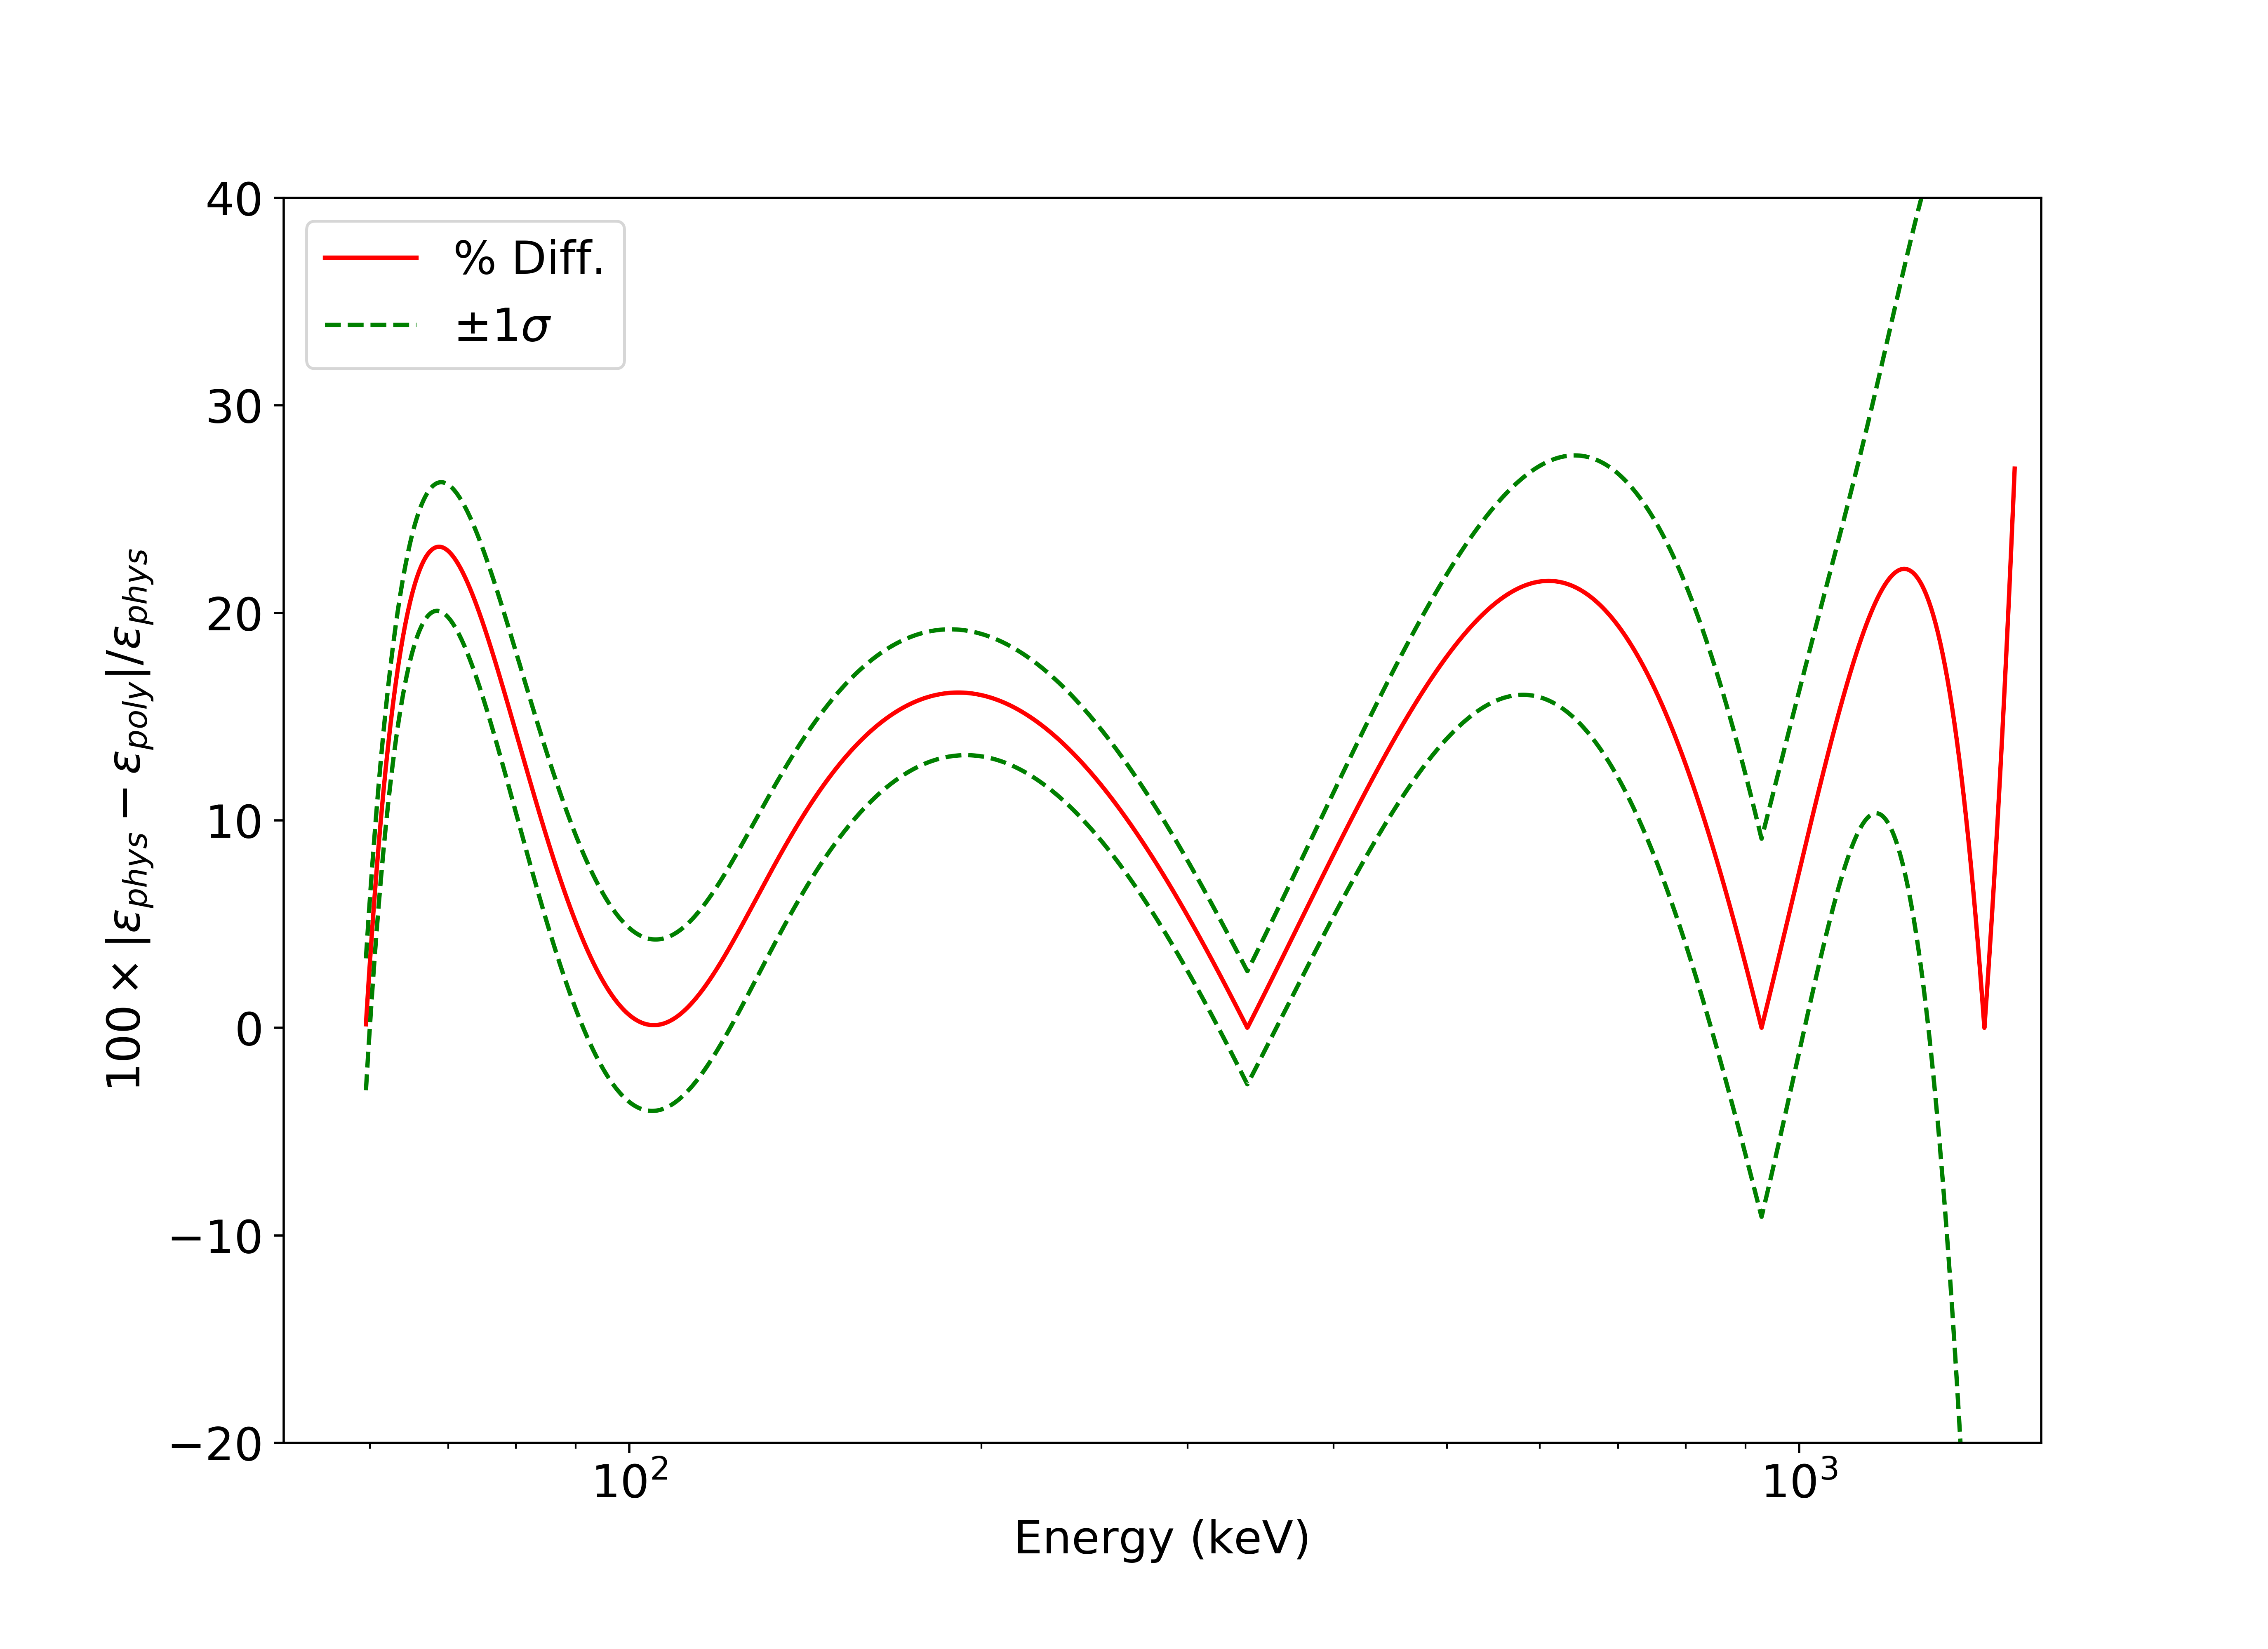

<Figure size 792x576 with 0 Axes>

In [16]:
#Obtain the percent difference
x_data = numpy.linspace( min(energies), max(energies), 10000 )
y_data_poly = numpy.polyval( B_poly, numpy.log(x_data) )
y_data_poly_err = logpoly_eff_MCerr( numpy.log(x_data), trials_res_poly )
y_data_phys = physical_eff1( x_data, *B_phys )
y_data_phys_err = physical_eff1_MCerr( x_data, trials_res_phys )

percent_diff = abs( y_data_phys - y_data_poly ) / y_data_phys * 100.0 
percent_diff_unc = numpy.sqrt( y_data_phys_err**2.0 + y_data_poly_err**2.0 ) / y_data_phys * 100.0 
percent_diff_unc_top = percent_diff + percent_diff_unc
percent_diff_unc_bot = percent_diff - percent_diff_unc

#Plot the percent different
plt.plot( x_data, percent_diff, 'r', label='% Diff.' )
plt.plot( x_data, percent_diff_unc_top, 'g--', label=r'$\pm 1 \sigma$' )
plt.plot( x_data, percent_diff_unc_bot, 'g--' )
plt.xlabel('Energy (keV)')
plt.ylabel(r'$100 \times |\varepsilon_{phys} - \varepsilon_{poly}| / \varepsilon_{phys}$')
plt.legend()
plt.xscale('log')
plt.axis( [-10, 1610, -20, 40] )
plt.savefig( '../images/perc_diff.png', dpi=500 )
plt.savefig( '../images/perc_diff.eps', format='eps' )
plt.clf()
Image('../images/perc_diff.png')